In this notebook, we analyse the prediction accuracies and contributing weights of each single-channel to the stacked LASSO model. In addition, we also plot these, which correspond to all panels in Figure 2 of the paper.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as opj
import seaborn as sns
import h5py
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import wilcoxon

In [2]:
f_res = h5py.File(opj('../results', 'scores.hdf5'), 'r')

comb_r2_scores = f_res['comb_2_scores'][:]
single_r2_scores = f_res['single_r2_scores'][:]
comb_weights = f_res['comb_weights'][:]

f_res.close()

In [3]:
f_preds = h5py.File(opj('../results', 'predictions.hdf5'), 'r')
preds_dict = {}

for score, mc_preds in f_preds.items():
    preds_dict[score] = mc_preds[:]
f_preds.close()

In [4]:
score_names = ['Global Cognitive Function',
               'Fluid Intelligence', 
               'Crystallized Intelligence', 
               'Sustained Attention',
               'Impulsivity',
               'Verbal Episodic Memory', 
               'Spatial Orientation']


modality_names = ['RESTING-STATE \n CONNECTIVITY', 'CORTICAL \n SURFACE', 
                  'CORTICAL \n THICKNESS', 'SUBCORTICAL \n VOLUME', 'LOCAL \n CONNECTOME']
n_scores = len(score_names)
n_mods = len(modality_names)

# Individual and stacked modality performances 

In [5]:
# Set aesthetics for plots
sns.set_style(style='darkgrid')
sns.set_context("paper")
sns.set(font="Arial")

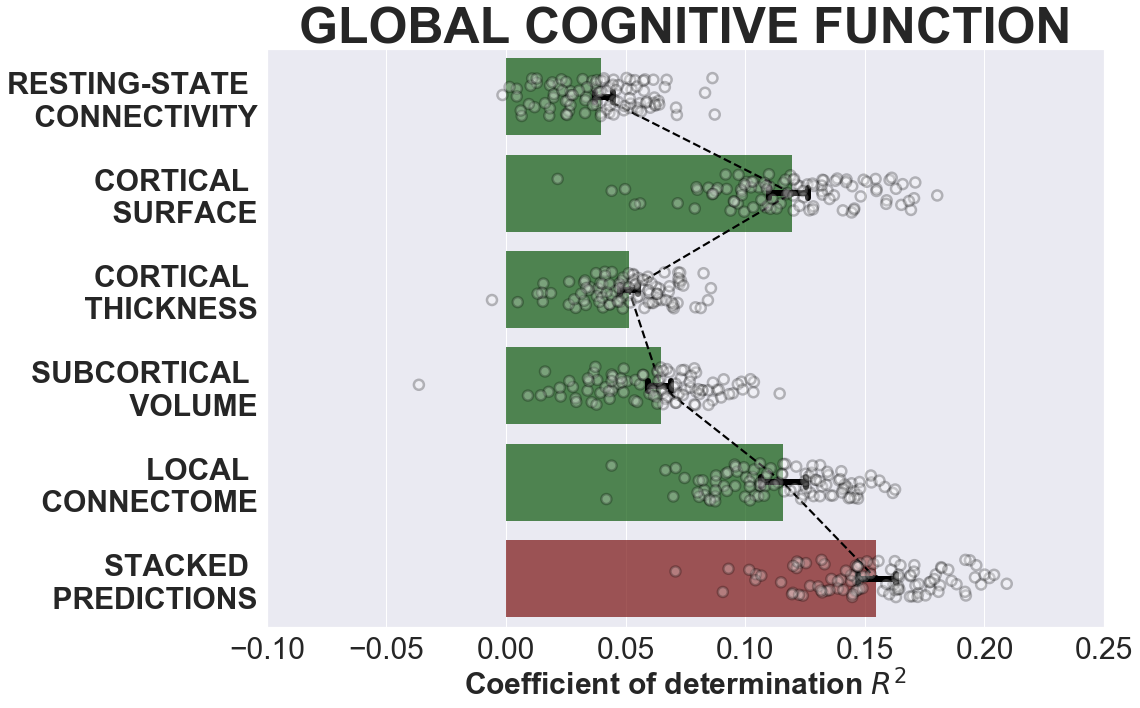

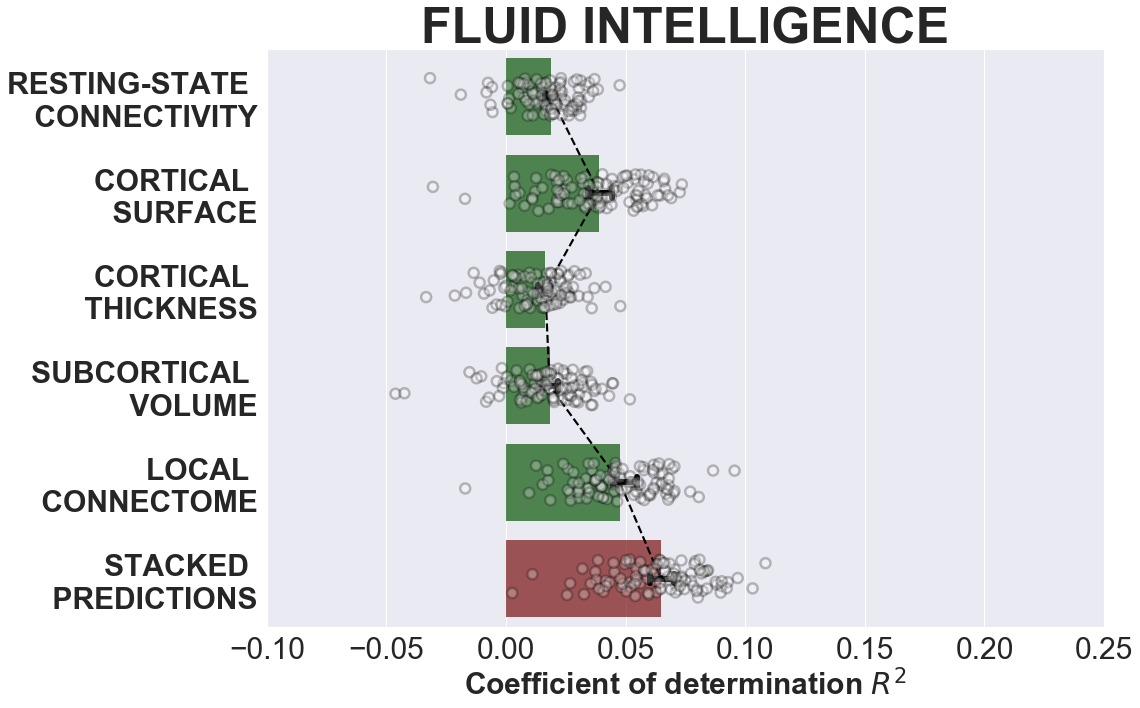

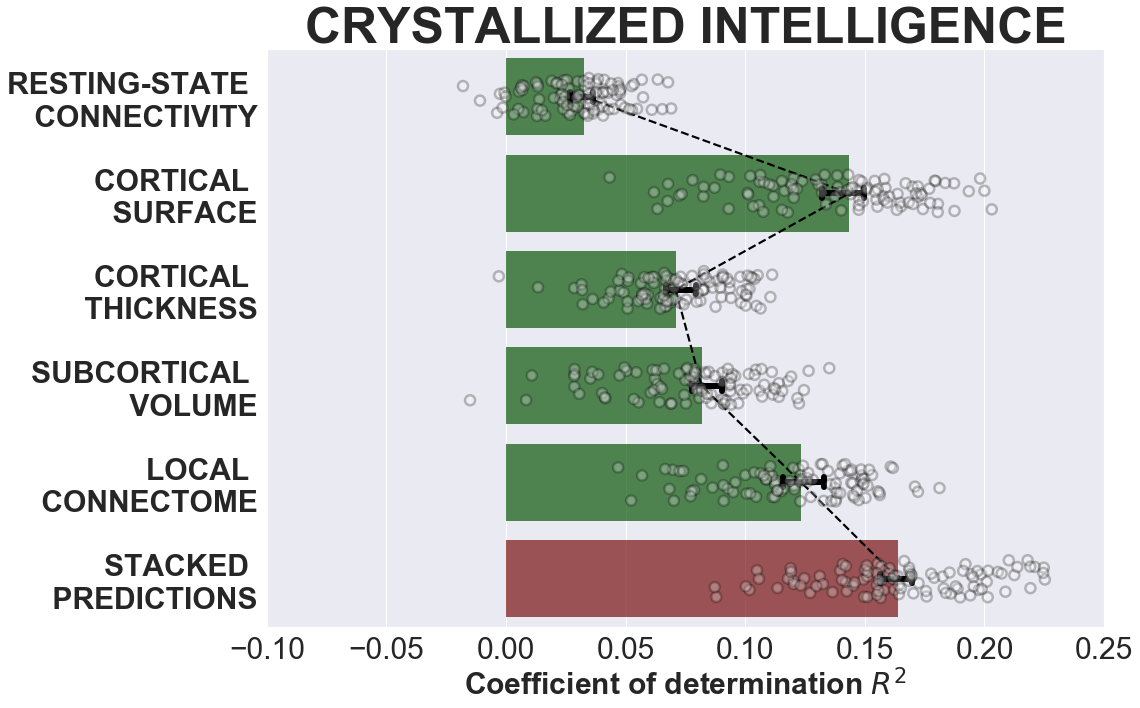

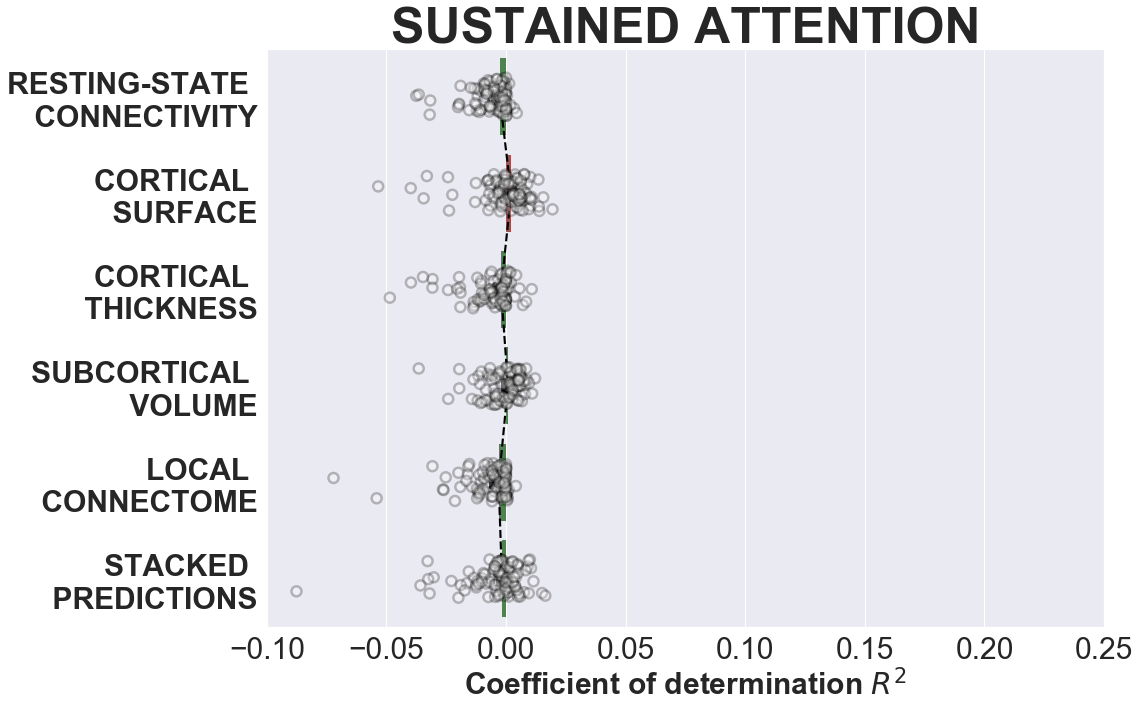

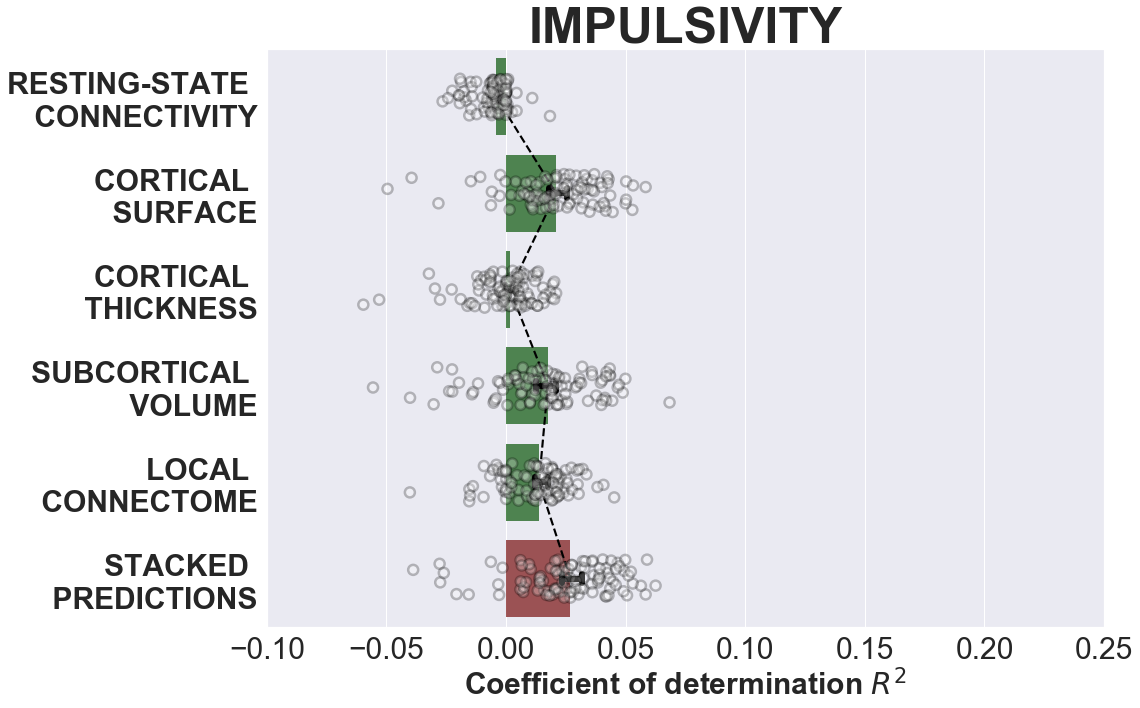

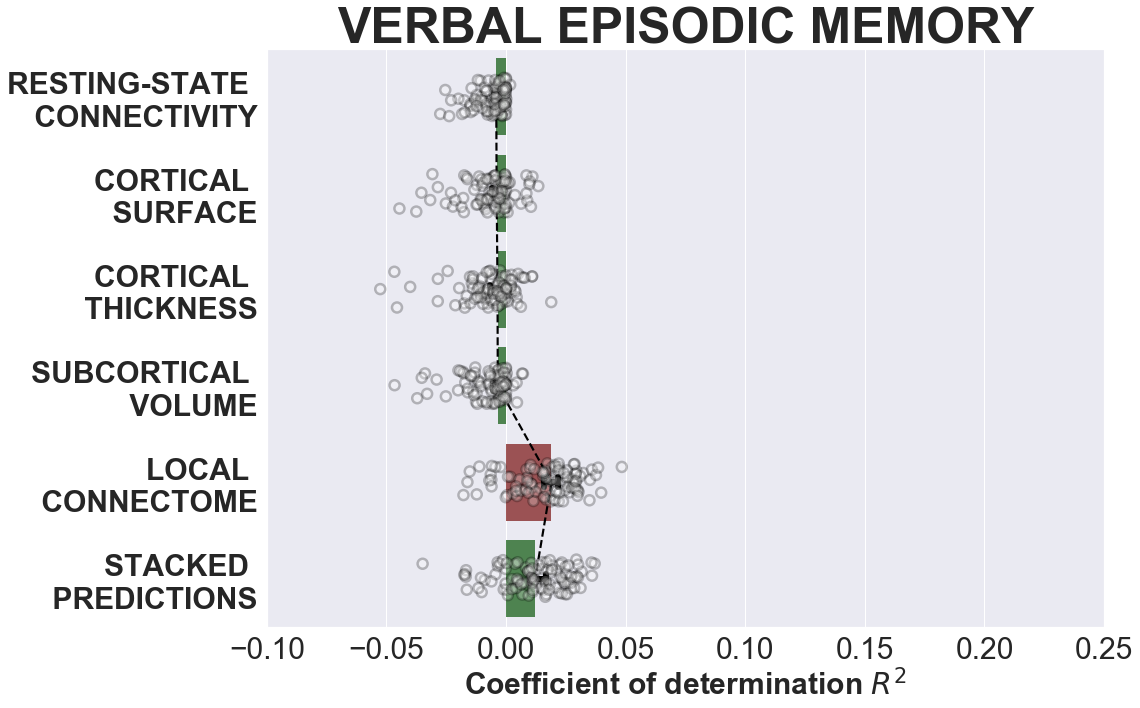

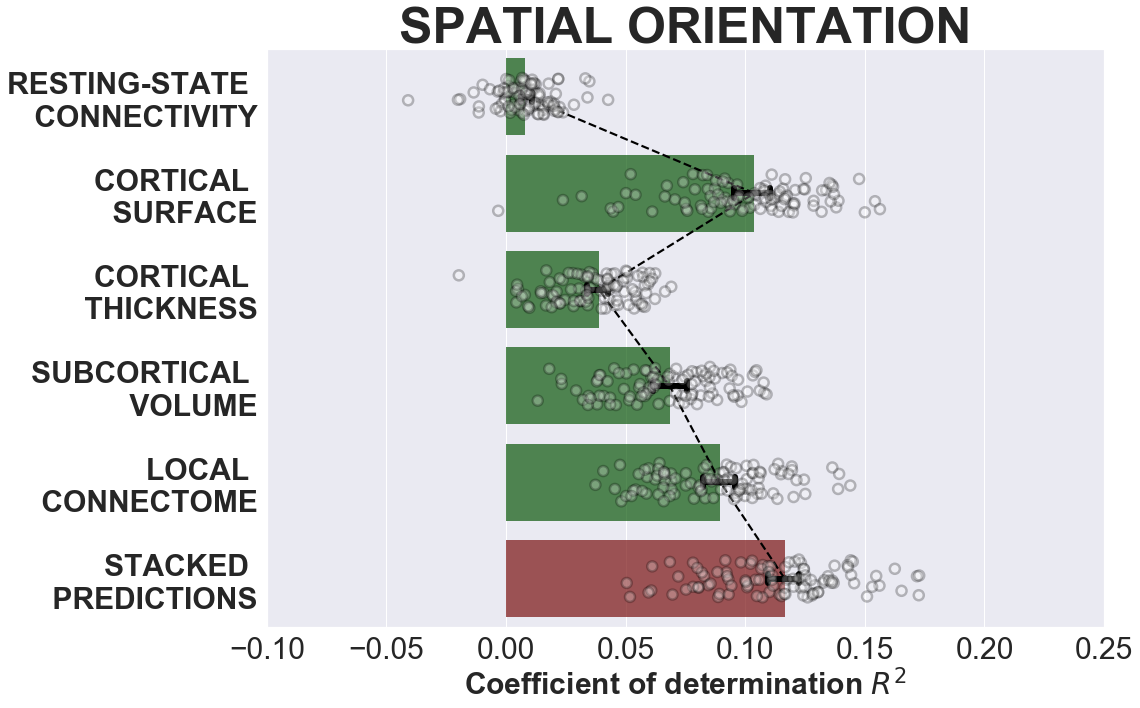

In [18]:
for ii in range(n_scores):
    fig, ax = plt.subplots(figsize=(16,10))

    temp_dict = dict()
    for  jj, name in enumerate(modality_names):
        temp_dict[name] = single_r2_scores[:, ii, jj] 
    temp_dict['STACKED'] = comb_r2_scores[:, ii]
    
    temp_df = pd.melt(pd.DataFrame(temp_dict))
    
    sns.stripplot(y='variable', 
                  x='value',
                  data=temp_df,
                  size= 10,
                  alpha=0.25,
                  jitter=0.2,
                  linewidth = 2.5,
                  color = 'white',
                  edgecolor ='black',
                  ax = ax)
    
    sns.pointplot(y='variable', 
            x='value',
            data=temp_df,
            estimator = np.median, 
              seed = 0, 
              color='black',
              errwidth=6,
              capsize=.1,
                  linestyles='--',
              scale=0.8,
                errcolor=".05",
              ax=ax)
    

    median_values = list(np.median(single_r2_scores, axis=0)[ii, :]) +  [np.median(comb_r2_scores[:, ii])]
    clr_palette = ['darkgreen' if x<max(median_values) else  'darkred' for x in median_values]
    sns.barplot(y='variable', 
                x='value',
                data=temp_df,
                estimator = np.median,
                capsize=0,
                linewidth=0.,#2.5,
                errwidth = 0,
                errcolor=".05", edgecolor=".05",
                alpha=0.7,
                palette = clr_palette,
                ax = ax)

    for patch in ax.patches :
        current_width = patch.get_height()
        diff = current_width - 0.8

        # we change the bar width
        patch.set_height(0.8)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)
    
    ax.set_ylabel("")
    ax.set_xlabel(r'Coefficient of determination $R^2$', size=30, weight = 'bold')
    
    ax.tick_params(axis='x', labelsize=30)
    ax.set_yticklabels(modality_names + ['STACKED \n PREDICTIONS'], size=30,  weight = 'bold')
    ax.set_title(score_names[ii].upper(), size=50, weight = 'bold', loc='center')
    plt.xlim([-0.1, 0.25])
    plt.tight_layout()
    plt.savefig(opj("../plots/results/%s_r2_scores.png" % score_names[ii]), dpi=300)
    plt.savefig(opj("../plots/results/%s_r2_scores.svg" % score_names[ii]), dpi=300)
    pass

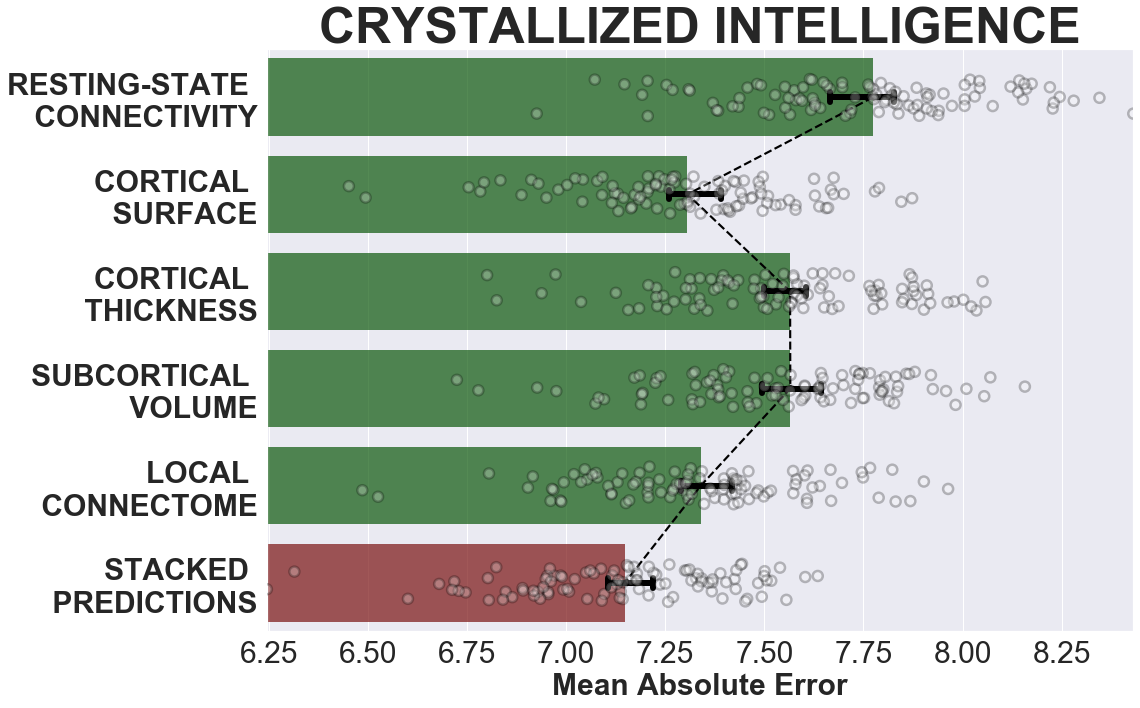

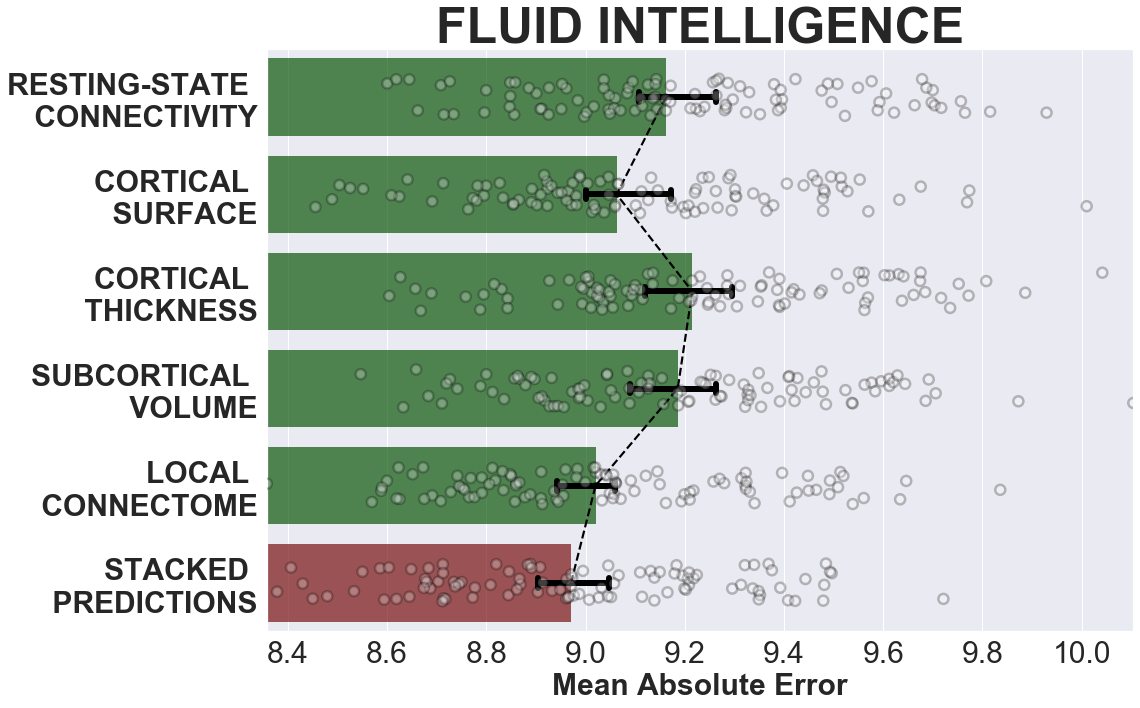

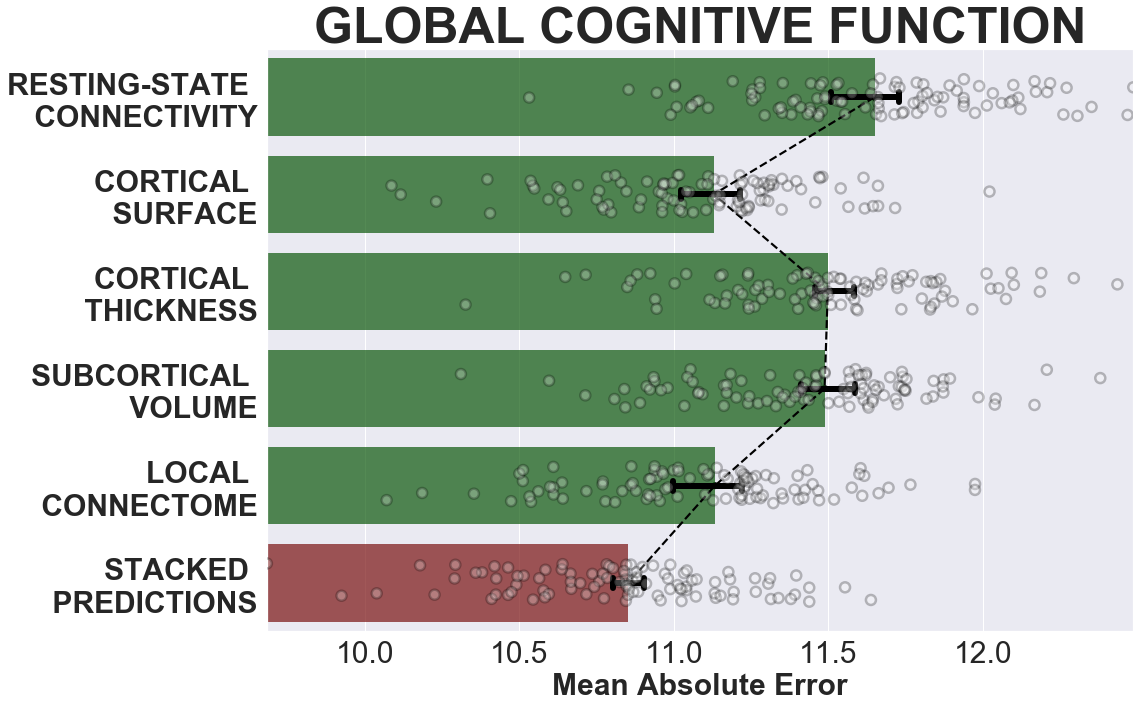

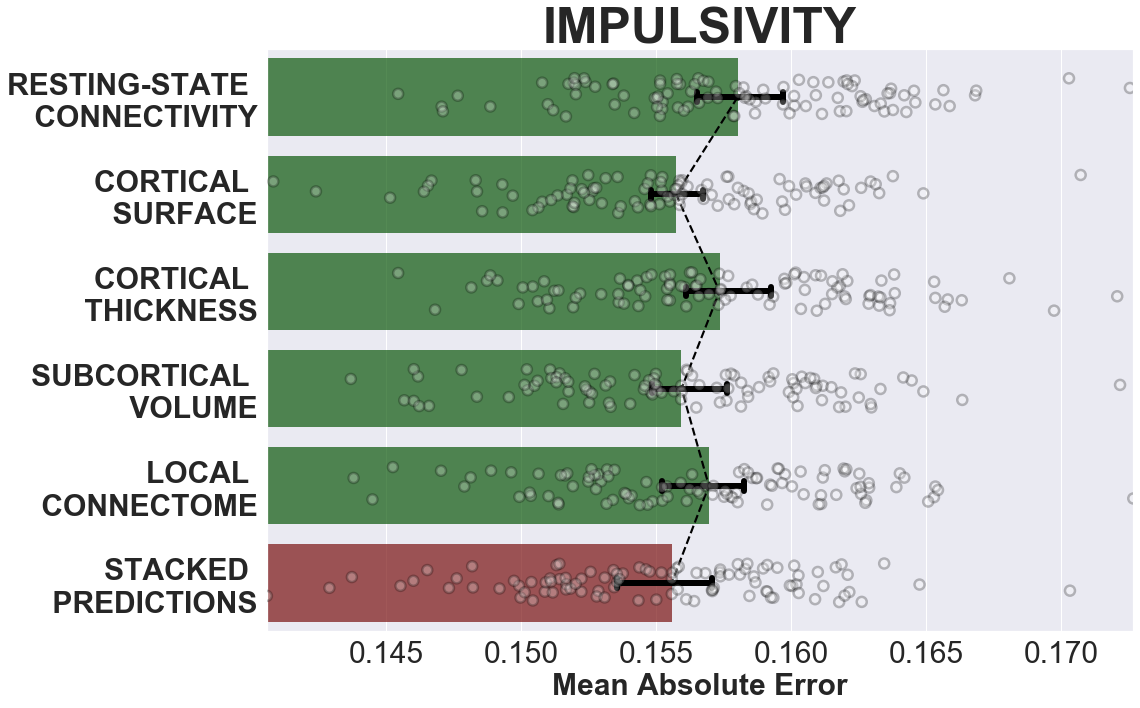

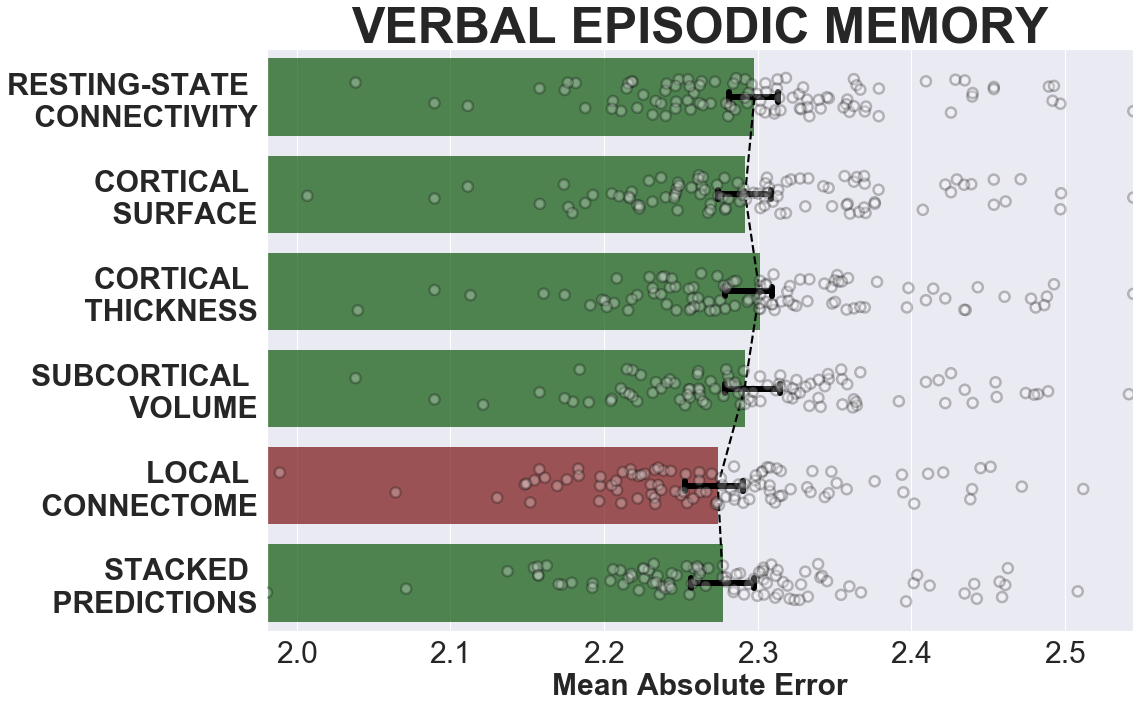

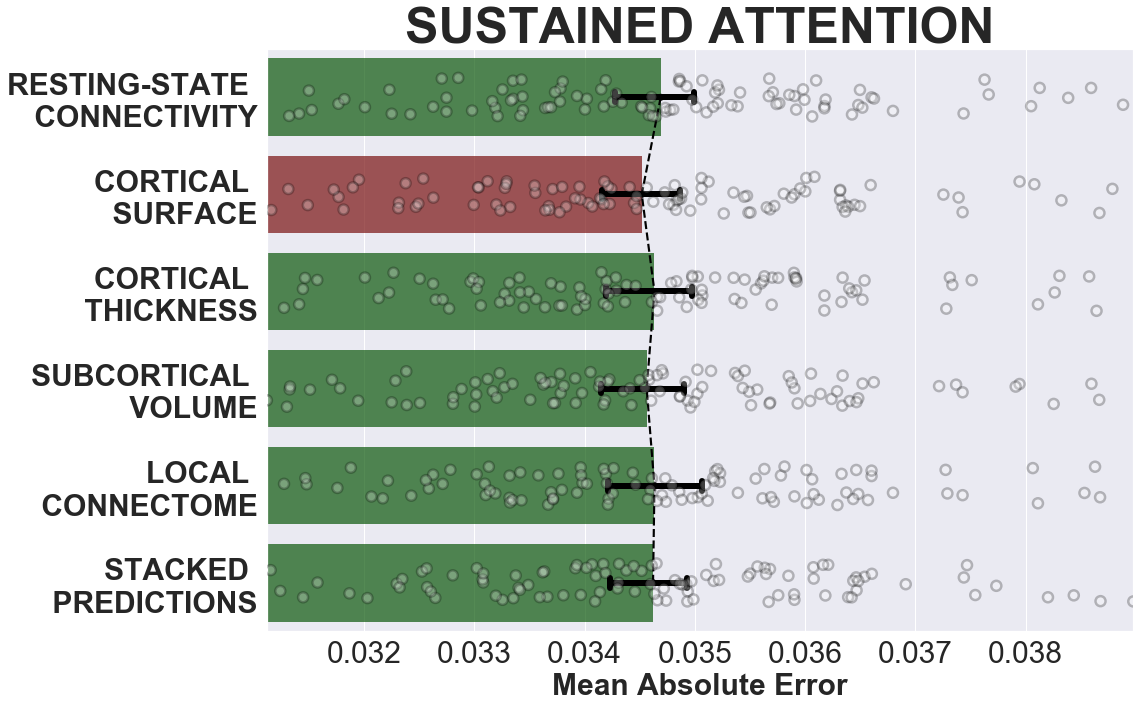

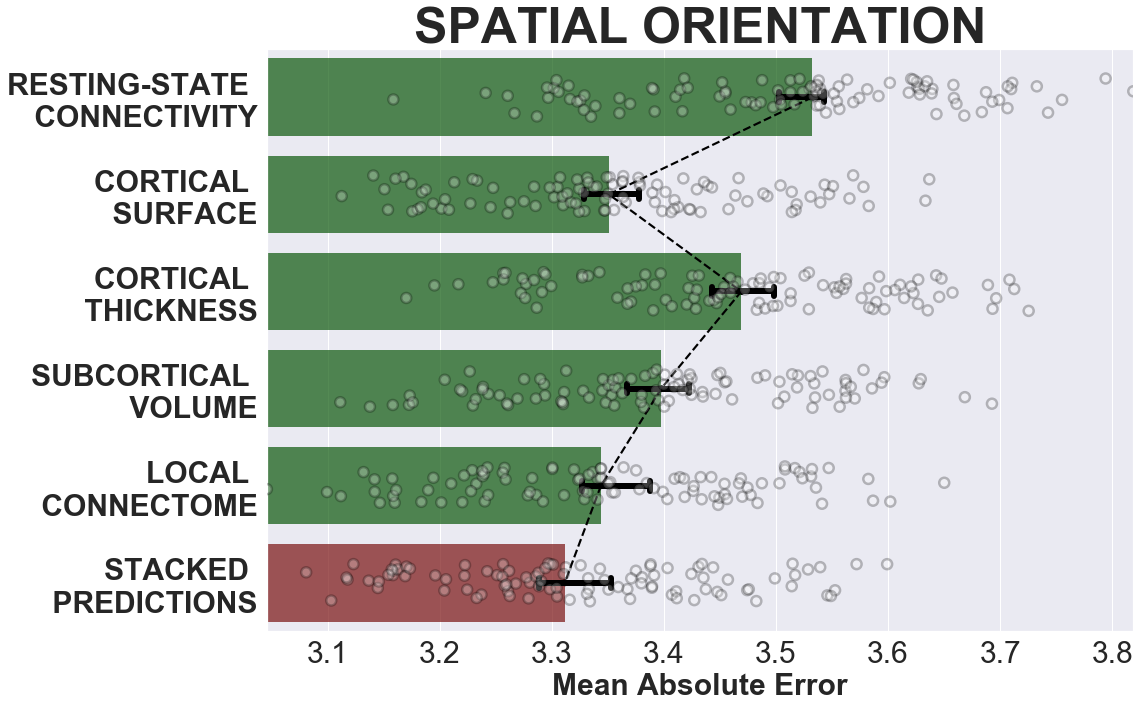

In [19]:
#The same with MAE
for ii, score in enumerate(preds_dict.keys()):
    
    if score=='CogTotalComp_Unadj':
        score_name = score_names[0]
    elif score=='CogFluidComp_Unadj':
        score_name =  score_names[1]
    elif score == 'CogCrystalComp_Unadj':
        score_name = score_names[2]
    elif score == 'DDisc_AUC_200':
        score_name = score_names[4]
    elif  score == 'SCPT_SEN':
        score_name =  score_names[3]
    elif score == 'IWRD_TOT':
        score_name = score_names[5]
    else:
         score_name = score_names[6]
            
    fig, ax = plt.subplots(figsize=(16,10))

    temp_dict = dict()
    for  jj, name in enumerate(modality_names):
        temp_dict[name] = [mean_absolute_error(preds_dict[score][mc_i, :, jj], preds_dict[score][mc_i, :, 6]) \
                           for mc_i in range(100)]
        
    temp_dict['STACKED'] = [mean_absolute_error(preds_dict[score][mc_i, :, 5],  preds_dict[score][mc_i, :, 6]) \
                            for mc_i in range(100)]
    
    temp_df = pd.melt(pd.DataFrame(temp_dict))
    

    sns.stripplot(y='variable', 
                  x='value',
                  data=temp_df,
                  size= 10,
                  alpha=0.25,
                  jitter=0.2,
                  linewidth = 2.5,
                  color = 'white',
                  edgecolor ='black',
                  ax = ax)
    
    sns.pointplot(y='variable', 
            x='value',
            data=temp_df,
            estimator = np.median, 
              seed = 0, 
              color='black',
              errwidth=6,
              capsize=.1,
                  linestyles='--',
              scale=0.8,
                errcolor=".05",
              ax=ax)
    

    median_values = list(pd.DataFrame(temp_dict).median(axis=0).values)
    clr_palette = ['darkgreen' if x>min(median_values) else  'darkred' for x in median_values]
    sns.barplot(y='variable', 
                x='value',
                data=temp_df,
                estimator = np.median,
                capsize=0,
                linewidth=0.,#2.5,
                errwidth = 0,
                errcolor=".05", edgecolor=".05",
                alpha=0.7,
                palette = clr_palette,
                ax = ax)

    for patch in ax.patches :
        current_width = patch.get_height()
        diff = current_width - 0.8

        # we change the bar width
        patch.set_height(0.8)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)
    
    ax.set_ylabel("")
    ax.set_xlabel("Mean Absolute Error", size=30, weight = 'bold')
    
    ax.tick_params(axis='x', labelsize=30)
    ax.set_yticklabels(modality_names + ['STACKED \n PREDICTIONS'], size=30,  weight = 'bold')
    ax.set_title(score_name.upper(), size=50, weight = 'bold', loc='center')
    
    plt.xlim([temp_df.value.min(), temp_df.value.max()])
    plt.tight_layout()
    plt.savefig(opj("../plots/results/%s_mae_scores.png" % score_name), dpi=300)
    plt.savefig(opj("../plots/results/%s_mae_scores.svg" % score_name), dpi=300)
    pass

### Compute Confidence intervals

In [6]:
def compute_ci(sample, estimator = np.mean, alpha=0.05, n_boots=1000, seed=None):
    
    from sklearn.utils import resample
    from collections import namedtuple
    if seed:
        np.random.seed(seed)
        
    # Allow for a function that is the name of a method on an array
    if isinstance(estimator, str):
        def f(x):
            return getattr(x, estimator)()
    else:
        f = estimator
        
    boot_samples = [ f(resample(sample)) for ii in range(n_boots)]
    
    l_ci, u_ci = np.quantile(boot_samples, q=[alpha/2., 1-alpha/2.])
    CI = namedtuple('ConfidenceIntervals', ['low', 'high'])
    return CI(l_ci, u_ci) 

In [8]:
for ii in range(7):
    print("TEST = %s" % score_names[ii])
    
    string = ""
    for jj in range(5):
        #print("MODALITY = %s" % modality_names[jj])
        median = np.median(single_r2_scores[:,ii, jj])
        l_ci, u_ci =  compute_ci(single_r2_scores[:,ii, jj], estimator=np.median, seed=0)
        string += "%s median R2 = %.6f, CI[%.6f, %.6f]\n" % (modality_names[jj], median, l_ci, u_ci)
    print(string)
    print(" ")

TEST = Cognitive Function Composite
RESTING-STATE 
 CONNECTIVITY median R2 = 0.039754, CI[0.036995, 0.045045]
CORTICAL 
 SURFACE median R2 = 0.119503, CI[0.109882, 0.125172]
CORTICAL 
 THICKNESS median R2 = 0.051266, CI[0.047248, 0.055340]
SUBCORTICAL 
 VOLUME median R2 = 0.064598, CI[0.058684, 0.068670]
LOCAL 
 CONNECTOME median R2 = 0.115709, CI[0.106364, 0.125136]

 
TEST = Fluid Cognition Composite
RESTING-STATE 
 CONNECTIVITY median R2 = 0.018741, CI[0.016368, 0.020500]
CORTICAL 
 SURFACE median R2 = 0.038818, CI[0.034543, 0.044191]
CORTICAL 
 THICKNESS median R2 = 0.016400, CI[0.013244, 0.018412]
SUBCORTICAL 
 VOLUME median R2 = 0.018235, CI[0.014786, 0.021650]
LOCAL 
 CONNECTOME median R2 = 0.047578, CI[0.044675, 0.054200]

 
TEST = Crystallized Cognition Composite
RESTING-STATE 
 CONNECTIVITY median R2 = 0.032669, CI[0.027512, 0.036301]
CORTICAL 
 SURFACE median R2 = 0.143487, CI[0.132641, 0.148913]
CORTICAL 
 THICKNESS median R2 = 0.070850, CI[0.066998, 0.079182]
SUBCORTICAL 


Median performance and confidence intervals of the stacked predictions

In [9]:
for ii in range(7):
    print("TEST = %s" % score_names[ii])
    median = np.median(comb_r2_scores[:,ii])
    l_ci, u_ci =  compute_ci(comb_r2_scores[:,ii], estimator=np.median, seed=0)
    print("median = %.6f, CI  [%.6f, %.6f]" % (median, l_ci, u_ci))
    print(" ")

TEST = Cognitive Function Composite
median = 0.154622, CI  [0.146989, 0.163883]
 
TEST = Fluid Cognition Composite
median = 0.064648, CI  [0.061158, 0.070066]
 
TEST = Crystallized Cognition Composite
median = 0.163890, CI  [0.156243, 0.169392]
 
TEST = Short Penn CPT Sensitivity
median = -0.001733, CI  [-0.002960, -0.000090]
 
TEST = Delay Discounting:
 AUC for Discounting of $200
median = 0.026861, CI  [0.022751, 0.031332]
 
TEST = Penn Word Memory: 
 Total Number of Correct Responses
median = 0.012151, CI  [0.009906, 0.016490]
 
TEST = Penn Line Orientation: 
 Total Number Correct
median = 0.116479, CI  [0.109533, 0.122415]
 


# Testing differences

Perform a Friedman Chi2 testing to see for each score if a statistical difference exists across single and stacked predictions. If it does, a follo-up wilcoxon pairwise testing with bonferroni corrections is performed to check whether such differences are across the five individual channels compared to stacked prediction

In [17]:
from scipy.stats import wilcoxon, friedmanchisquare

In [26]:
print("------------------------------------------------------------------")
for ii in range(n_scores):
    foo = [single_r2_scores[:, ii, jj] for jj in range(n_mods)] + [comb_r2_scores[:, ii]]
    _, p = friedmanchisquare(*foo)


    print("Friedman Chi2 p-value for test %s = %.2e" % (score_names[ii], p))
    print("------------------------------------------------------------------")

------------------------------------------------------------------
Friedman Chi2 p-value for test Cognitive Function Composite = 1.16e-89
------------------------------------------------------------------
Friedman Chi2 p-value for test Fluid Cognition Composite = 1.98e-72
------------------------------------------------------------------
Friedman Chi2 p-value for test Crystallized Cognition Composite = 1.54e-93
------------------------------------------------------------------
Friedman Chi2 p-value for test Short Penn CPT Sensitivity = 1.20e-22
------------------------------------------------------------------
Friedman Chi2 p-value for test Delay Discounting:
 AUC for Discounting of $200 = 1.43e-50
------------------------------------------------------------------
Friedman Chi2 p-value for test Penn Word Memory: 
 Total Number of Correct Responses = 1.78e-51
------------------------------------------------------------------
Friedman Chi2 p-value for test Penn Line Orientation: 
 Total 

Test which single predictions are smaller than combining them (1-sided Wilcoxon test with bonferroni corrections)

In [39]:
# compute number of posthoc hypthesis tests to correct for bonferroni
fwe = n_mods*(n_scores) 
n_obs = 100

In [40]:
for ii in range(n_scores):
    print("-----------------------")
    print(score_names[ii])
    print("-----------------------")
    
    for jj in range(n_mods):
        w, p = wilcoxon(single_r2_scores[:, ii, jj], comb_r2_scores[:, ii], alternative = 'less')
        #z  = 1 - w/n_obs**2
        z  = w/np.sqrt(2*n_obs)
        p_bonf =  p*fwe
        
        if p_bonf>1:
            p_bonf=1
        print("%s, median R2 = %.3f,"
              " z = %f, p_bonferroni = %.3e" % (modality_names[jj], 
                                                np.median(single_r2_scores[:, ii, jj]),
                                                   z, p_bonf))
    print(" ")    
    print("STACKED MODALITY median R2 = %.3f " % np.median(comb_r2_scores[:, ii]))
    print(" ")

-----------------------
Global Cognitive Function
-----------------------
RESTING-STATE 
 CONNECTIVITY, median R2 = 0.040, z = 0.000000, p_bonferroni = 6.819e-17
CORTICAL 
 SURFACE, median R2 = 0.120, z = 0.141421, p_bonferroni = 7.244e-17
CORTICAL 
 THICKNESS, median R2 = 0.051, z = 0.000000, p_bonferroni = 6.819e-17
SUBCORTICAL 
 VOLUME, median R2 = 0.065, z = 0.000000, p_bonferroni = 6.819e-17
LOCAL 
 CONNECTOME, median R2 = 0.116, z = 0.212132, p_bonferroni = 7.466e-17
 
STACKED MODALITY median R2 = 0.155 
 
-----------------------
Fluid Intelligence
-----------------------
RESTING-STATE 
 CONNECTIVITY, median R2 = 0.019, z = 0.000000, p_bonferroni = 6.819e-17
CORTICAL 
 SURFACE, median R2 = 0.039, z = 1.979899, p_bonferroni = 1.583e-16
CORTICAL 
 THICKNESS, median R2 = 0.016, z = 0.000000, p_bonferroni = 6.819e-17
SUBCORTICAL 
 VOLUME, median R2 = 0.018, z = 0.212132, p_bonferroni = 7.466e-17
LOCAL 
 CONNECTOME, median R2 = 0.048, z = 21.566757, p_bonferroni = 4.011e-13
 
STACKED 

Looking at the results, we can summarise the following:
    
    - An overall statistical performance improvement of stacking with respect to each individual modality takes place for Cognitive Function Composite, Fluid Cognition Composite, Crystallized Cognition Composite, 
    Delay Discounting and Penn Line Orientation
    
    - For Penn Word Memory, Local Connectome predictions are better than stacking.
    
    - For Short Penn CPT Sensitivity, cortical surface area features give the highest performance, which is almost zero, meaning that no effective prediction exists whatsover.

Compare best single-channel performance with the rest of channels

In [41]:
for kk in [0,1, 2, 4, 6]:
    score  = score_names[kk]
    
    print("INDIVIDUAL METRIC RESULTS FOR %s" % score)
    print("-----------------------------------------")

    best_mod_i  = np.argmax(np.median(single_r2_scores[:, kk, :], axis=0))
    best_mod  = modality_names[best_mod_i]

    for ii, mod in enumerate(modality_names):
        if ii == best_mod_i:
            continue

        w, p = wilcoxon(single_r2_scores[:, kk, ii], 
                        single_r2_scores[:, kk, best_mod_i], alternative='less')
        z  = w/np.sqrt(2*n_obs)
        print("w, = %.3f, z = %.3f" % (w,z))
        if p<0.001:
            p_str = str("< 0.001")
        else:
            p_str = str(np.round(p, 3))

        print(" The p-value for performance"
              " between %s (R2 = %.3f) and (Best)" 
              " %s (R2 = %.3f)  =  %s " % (mod,
                                           np.median(single_r2_scores[:, kk, ii]),
                                           best_mod,
                                           np.median(single_r2_scores[:, kk, best_mod_i]),
                                           p_str))
        print(" ")

INDIVIDUAL METRIC RESULTS FOR Global Cognitive Function
-----------------------------------------
w, = 2.000, z = 0.141
 The p-value for performance between RESTING-STATE 
 CONNECTIVITY (R2 = 0.040) and (Best) CORTICAL 
 SURFACE (R2 = 0.120)  =  < 0.001 
 
w, = 12.000, z = 0.849
 The p-value for performance between CORTICAL 
 THICKNESS (R2 = 0.051) and (Best) CORTICAL 
 SURFACE (R2 = 0.120)  =  < 0.001 
 
w, = 3.000, z = 0.212
 The p-value for performance between SUBCORTICAL 
 VOLUME (R2 = 0.065) and (Best) CORTICAL 
 SURFACE (R2 = 0.120)  =  < 0.001 
 
w, = 2178.000, z = 154.008
 The p-value for performance between LOCAL 
 CONNECTOME (R2 = 0.116) and (Best) CORTICAL 
 SURFACE (R2 = 0.120)  =  0.116 
 
INDIVIDUAL METRIC RESULTS FOR Fluid Intelligence
-----------------------------------------
w, = 53.000, z = 3.748
 The p-value for performance between RESTING-STATE 
 CONNECTIVITY (R2 = 0.019) and (Best) LOCAL 
 CONNECTOME (R2 = 0.048)  =  < 0.001 
 
w, = 1302.000, z = 92.065
 The p-valu

STACKING BONUS

In [42]:
for kk in [0,1, 2,4, 6]:
    score  = score_names[kk]
    
    print("INDIVIDUAL METRIC RESULTS FOR %s" % score)
    print("-----------------------------------------")

    best_mod_i  = np.argmax(np.median(single_r2_scores[:, kk, :], axis=0))
    best_mod  = modality_names[best_mod_i]

    _, p = wilcoxon(single_r2_scores[:, kk, best_mod_i], 
                    comb_r2_scores[:, kk], 
                    alternative='less')
    
    stacking = comb_r2_scores[:, kk] - single_r2_scores[:, kk, best_mod_i]
    l,u = compute_ci(stacking, estimator=np.median, seed=0)
    print("stacking = %.3f, l = %.3f, u = %.3f" % (np.median(stacking), l, u))
    print(p)
    print(" ")

INDIVIDUAL METRIC RESULTS FOR Global Cognitive Function
-----------------------------------------
stacking = 0.035, l = 0.032, u = 0.040
2.0696869543572095e-18
 
INDIVIDUAL METRIC RESULTS FOR Fluid Intelligence
-----------------------------------------
stacking = 0.015, l = 0.013, u = 0.019
1.1460424816334462e-14
 
INDIVIDUAL METRIC RESULTS FOR Crystallized Intelligence
-----------------------------------------
stacking = 0.029, l = 0.025, u = 0.033
3.268051997305263e-17
 
INDIVIDUAL METRIC RESULTS FOR Impulsivity
-----------------------------------------
stacking = 0.006, l = 0.003, u = 0.009
0.0002817088465400053
 
INDIVIDUAL METRIC RESULTS FOR Spatial Orientation
-----------------------------------------
stacking = 0.016, l = 0.012, u = 0.019
7.834113264061517e-11
 


#  Second stage LASSO weights

Compute median confidence intervals around each weight channel to stacked LASSO model. This is only done for the 5 cognitive scores in which stacked led to a performance enhancement, i.e. Gobal Total Composite, Fluid Intelligence Composite, Crystallized Intelligence Composite, Delay Discount Test and Penn Line Orientation Test.

In [43]:
from sklearn.utils import resample

In [44]:
#Compute
n_boots = 1000

median_boot_weights = []

for i_boot in range(n_boots):
    
    w_boot = resample(comb_weights, random_state=i_boot)
    
    median_boot_weights.append(np.median(w_boot, 0))

(1000, 7, 5)

In [51]:
alpha = 0.05
l_ci, u_ci = np.quantile(np.vstack(([weights[np.newaxis,:,:] \
                                             for weights in median_boot_weights])),
                                 q=[alpha/2, 1-alpha/2], axis=0)

In [47]:
for ii in [0,1,2,4,6]:
    print("TEST = %s" % score_names[ii])
    
    string = ""
    for jj in range(5):
        median = np.median(comb_weights[:,ii, jj])
        lower, upper =  compute_ci(comb_weights[:,ii, jj], estimator=np.median, seed=0)
        string += "%s median beta = %.3f, CI[%.3f, %.3f]\n" % (modality_names[jj], median, lower, upper)
    print(string)
    print(" ")

TEST = Global Cognitive Function
RESTING-STATE 
 CONNECTIVITY median beta = 0.360, CI[0.330, 0.385]
CORTICAL 
 SURFACE median beta = 0.508, CI[0.480, 0.525]
CORTICAL 
 THICKNESS median beta = 0.193, CI[0.152, 0.223]
SUBCORTICAL 
 VOLUME median beta = 0.000, CI[0.000, 0.000]
LOCAL 
 CONNECTOME median beta = 0.560, CI[0.534, 0.585]

 
TEST = Fluid Intelligence
RESTING-STATE 
 CONNECTIVITY median beta = 0.514, CI[0.472, 0.560]
CORTICAL 
 SURFACE median beta = 0.462, CI[0.410, 0.516]
CORTICAL 
 THICKNESS median beta = 0.247, CI[0.163, 0.297]
SUBCORTICAL 
 VOLUME median beta = 0.000, CI[0.000, 0.075]
LOCAL 
 CONNECTOME median beta = 0.571, CI[0.535, 0.607]

 
TEST = Crystallized Intelligence
RESTING-STATE 
 CONNECTIVITY median beta = 0.224, CI[0.156, 0.285]
CORTICAL 
 SURFACE median beta = 0.535, CI[0.510, 0.566]
CORTICAL 
 THICKNESS median beta = 0.290, CI[0.261, 0.330]
SUBCORTICAL 
 VOLUME median beta = 0.000, CI[0.000, 0.000]
LOCAL 
 CONNECTOME median beta = 0.469, CI[0.432, 0.499]

 
TE

In [63]:
diff_zero = pd.DataFrame(data=(l_ci[[0,1,2,4,6],:]*u_ci[[0,1,2,4,6],:]>0), columns=modality_names)
diff_zero.index = np.array(score_names)[[0,1,2,4,6]]

In [64]:
diff_zero

RESTING-STATE \n CONNECTIVITY  CORTICAL \n SURFACE  \
Global Cognitive Function                           True                 True   
Fluid Intelligence                                  True                 True   
Crystallized Intelligence                           True                 True   
Impulsivity                                        False                 True   
Spatial Orientation                                False                 True   

                           CORTICAL \n THICKNESS  SUBCORTICAL \n VOLUME  \
Global Cognitive Function                   True                  False   
Fluid Intelligence                          True                  False   
Crystallized Intelligence                   True                  False   
Impulsivity                                False                   True   
Spatial Orientation                         True                  False   

                           LOCAL \n CONNECTOME  
Global Cognitive Function                 True  
Fluid Intelligence                        True  
Crystallized Intelligence                 True  
Impulsivity                               True  
Spatial Orientation                       True

We shall focus on Cognitive Function Composite, Fluid Cognition Composite, Crystallized Cognition Composite,  and Penn Line Orientation scores, since they are the ones where stacking really provides a performance enhancement. In particular, we will summarise for each of this scores which modality predictions exhibit a non zero median weight in the stacked Lasso model at the 0.05 level of significance:

- Cognitive composite score: All but volumes.

- Fluid Cognition Composite: All but volumes.

- Crystallized Cognition Composite: All but volumes.

- Penn Line Orientation: Cortical surface, cortical Thickness and Local connectome.

- Delay discounting: Cortical surface, Volume and Local connectome.

Compute statistical differences between the lasso weights

In [66]:
for kk in [0,1, 2, 4, 6]:
    score  = score_names[kk]
    
    print("INDIVIDUAL METRIC RESULTS FOR %s" % score)
    print("-----------------------------------------")

    best_mod_i  = np.argmax(np.median(comb_weights[:, kk, :], axis=0))
    best_mod  = modality_names[best_mod_i]

    for ii, mod in enumerate(modality_names):
        if ii == best_mod_i:
            continue

        w, p = wilcoxon(comb_weights[:, kk, best_mod_i], 
                        comb_weights[:, kk, ii], 
                        alternative='greater')
        count = 100
        
        foo = ((count*(count+1))/2) 
        print( 2*w/foo -1)
        #se = np.sqrt(count * (count + 1.) * (2. * count + 1.)/6)
        #print(w/se/10)
        #print(w/sum(np.arange(101)))
        #Correct for bonferroni
        p = p*4*5

        if p<0.001:
            p_str = str("< 0.001")
        else:
            p_str = str(np.round(p, 3))

        print(" The p-value for performance"
              " between %s (beta = %.3f) and (Best)" 
              " %s (beta = %.3f)  =  %s " % (mod,
                                           np.median(comb_weights[:, kk, ii]),
                                           best_mod,
                                           np.median(comb_weights[:, kk, best_mod_i]),
                                           p_str))
        print(" ")

INDIVIDUAL METRIC RESULTS FOR Global Cognitive Function
-----------------------------------------
0.91009900990099
 The p-value for performance between RESTING-STATE 
 CONNECTIVITY (beta = 0.360) and (Best) LOCAL 
 CONNECTOME (beta = 0.560)  =  < 0.001 
 
0.3405940594059407
 The p-value for performance between CORTICAL 
 SURFACE (beta = 0.508) and (Best) LOCAL 
 CONNECTOME (beta = 0.560)  =  0.031 
 
0.9984158415841584
 The p-value for performance between CORTICAL 
 THICKNESS (beta = 0.193) and (Best) LOCAL 
 CONNECTOME (beta = 0.560)  =  < 0.001 
 
0.9988118811881188
 The p-value for performance between SUBCORTICAL 
 VOLUME (beta = 0.000) and (Best) LOCAL 
 CONNECTOME (beta = 0.560)  =  < 0.001 
 
INDIVIDUAL METRIC RESULTS FOR Fluid Intelligence
-----------------------------------------
0.29782178217821786
 The p-value for performance between RESTING-STATE 
 CONNECTIVITY (beta = 0.514) and (Best) LOCAL 
 CONNECTOME (beta = 0.571)  =  0.097 
 
0.5172277227722772
 The p-value for perfor

Plot the weights distribution (Figure 3)

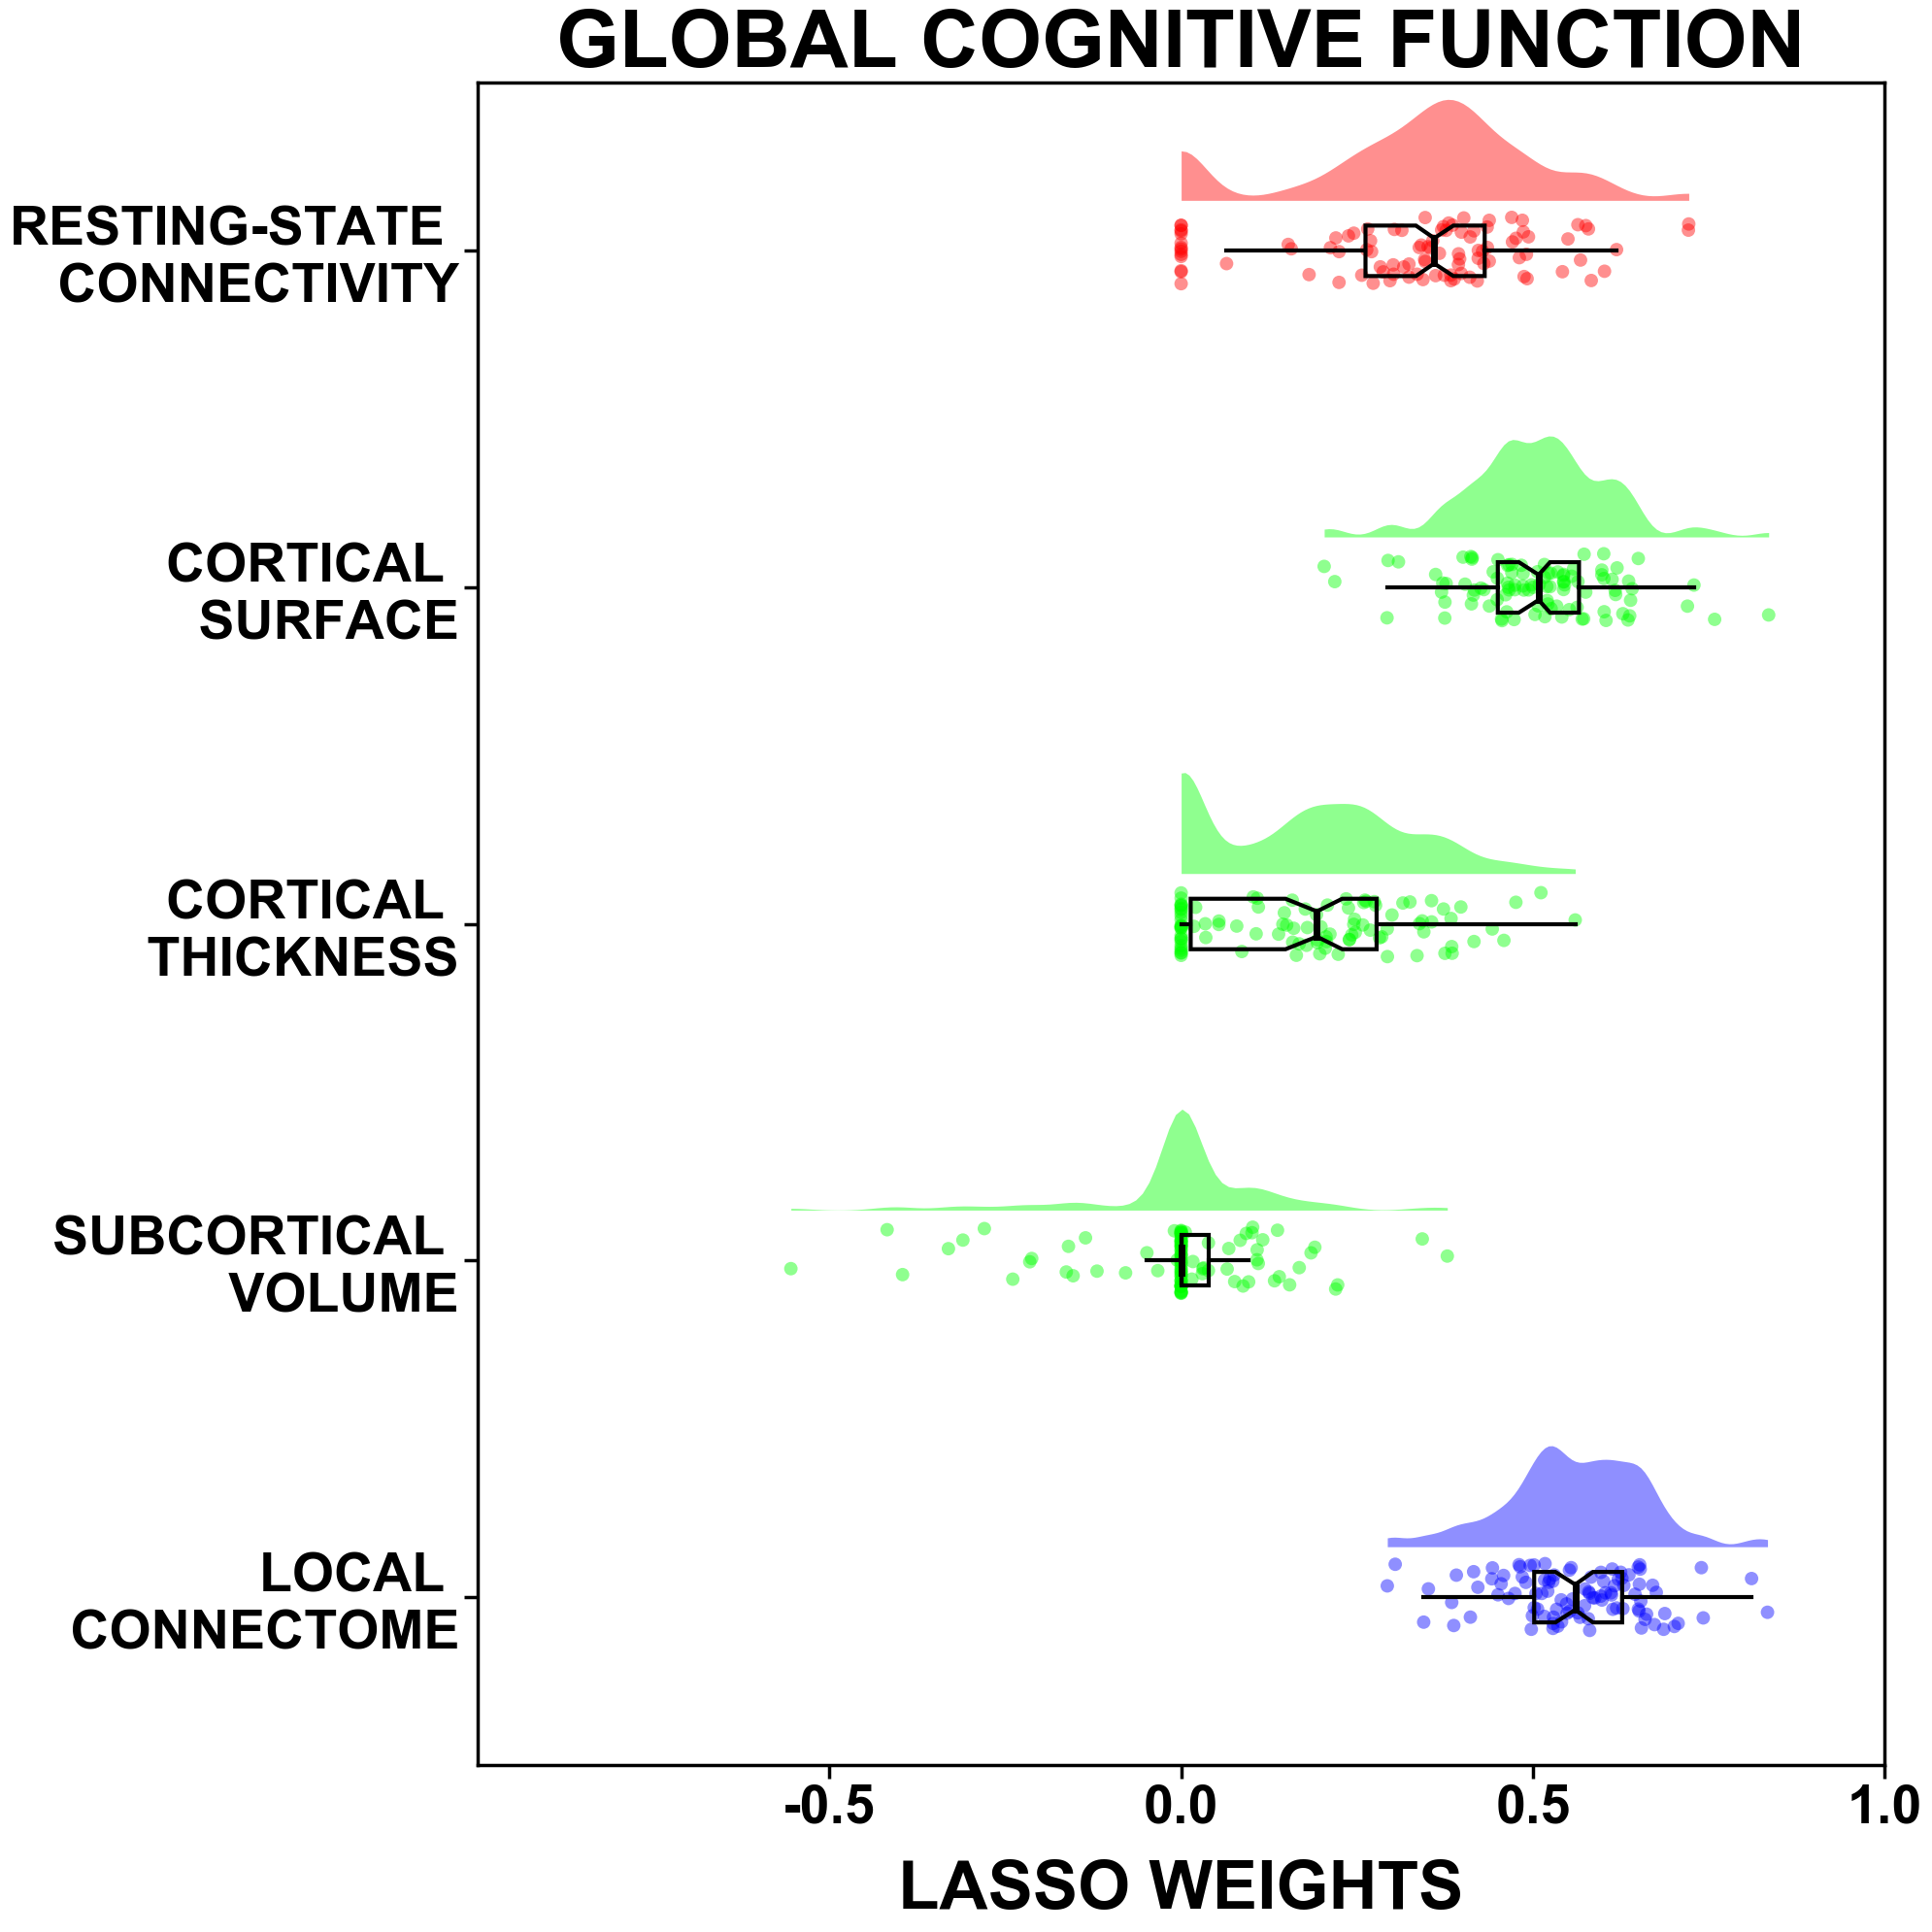

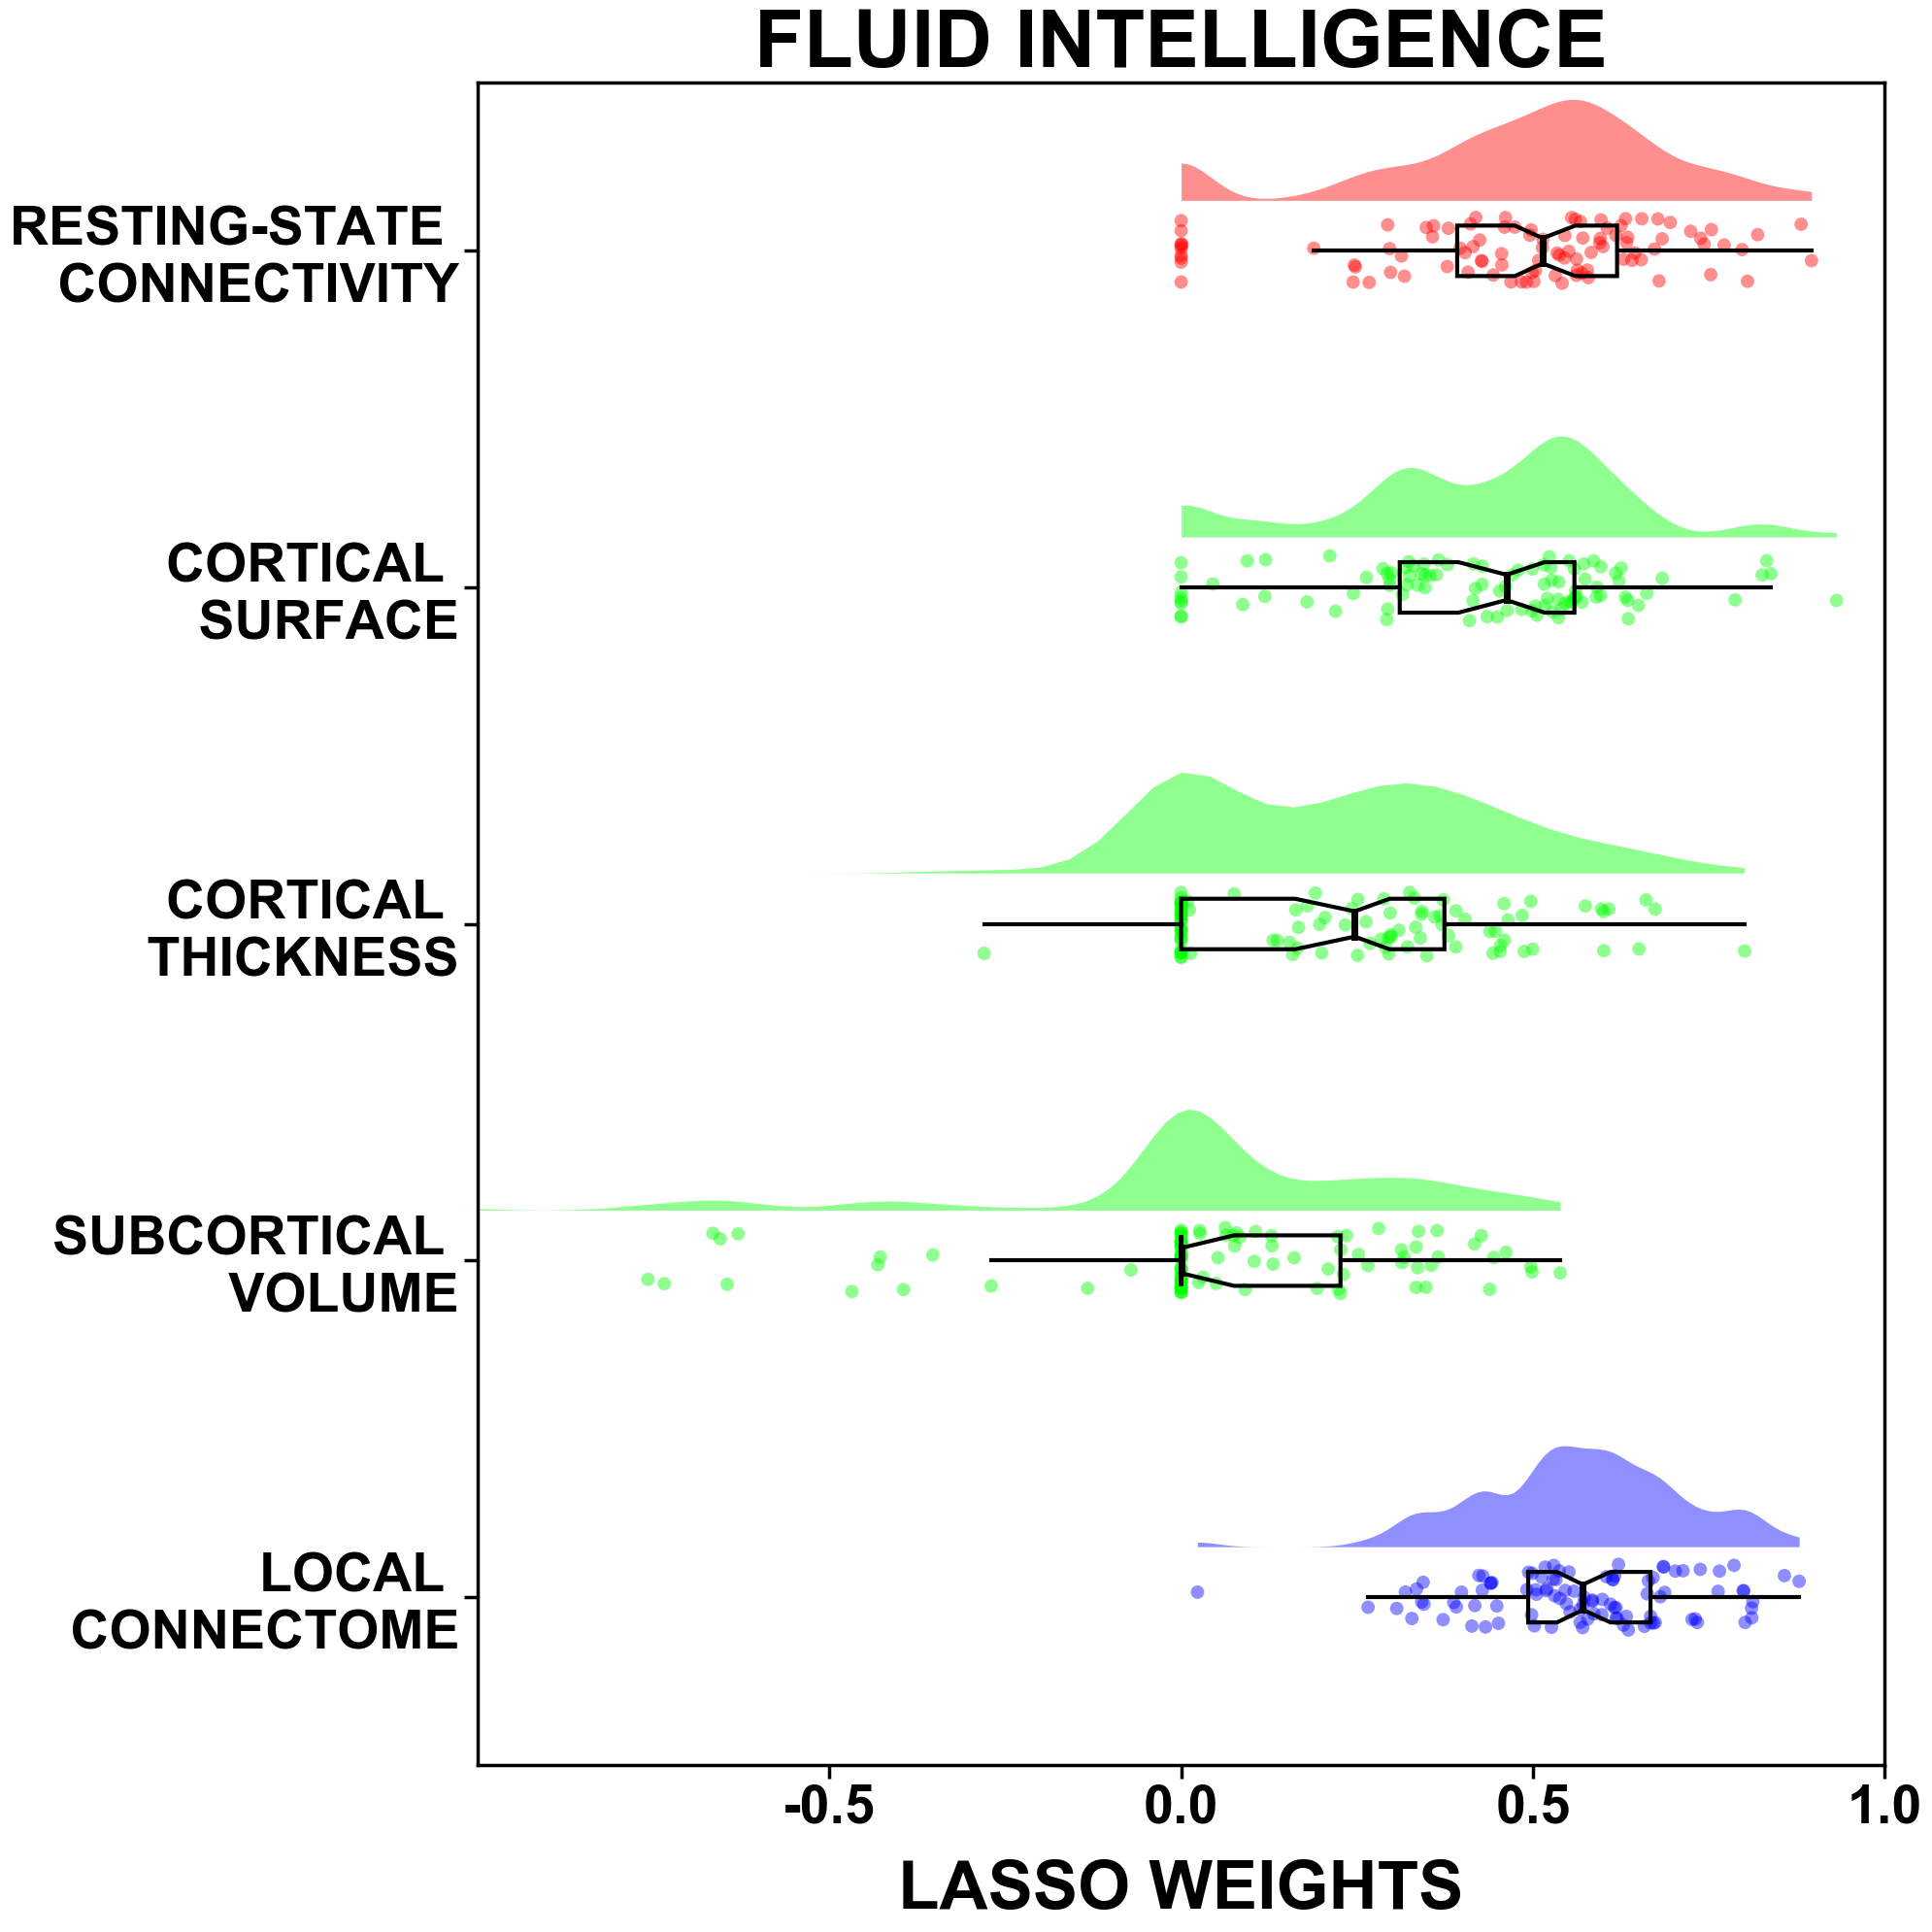

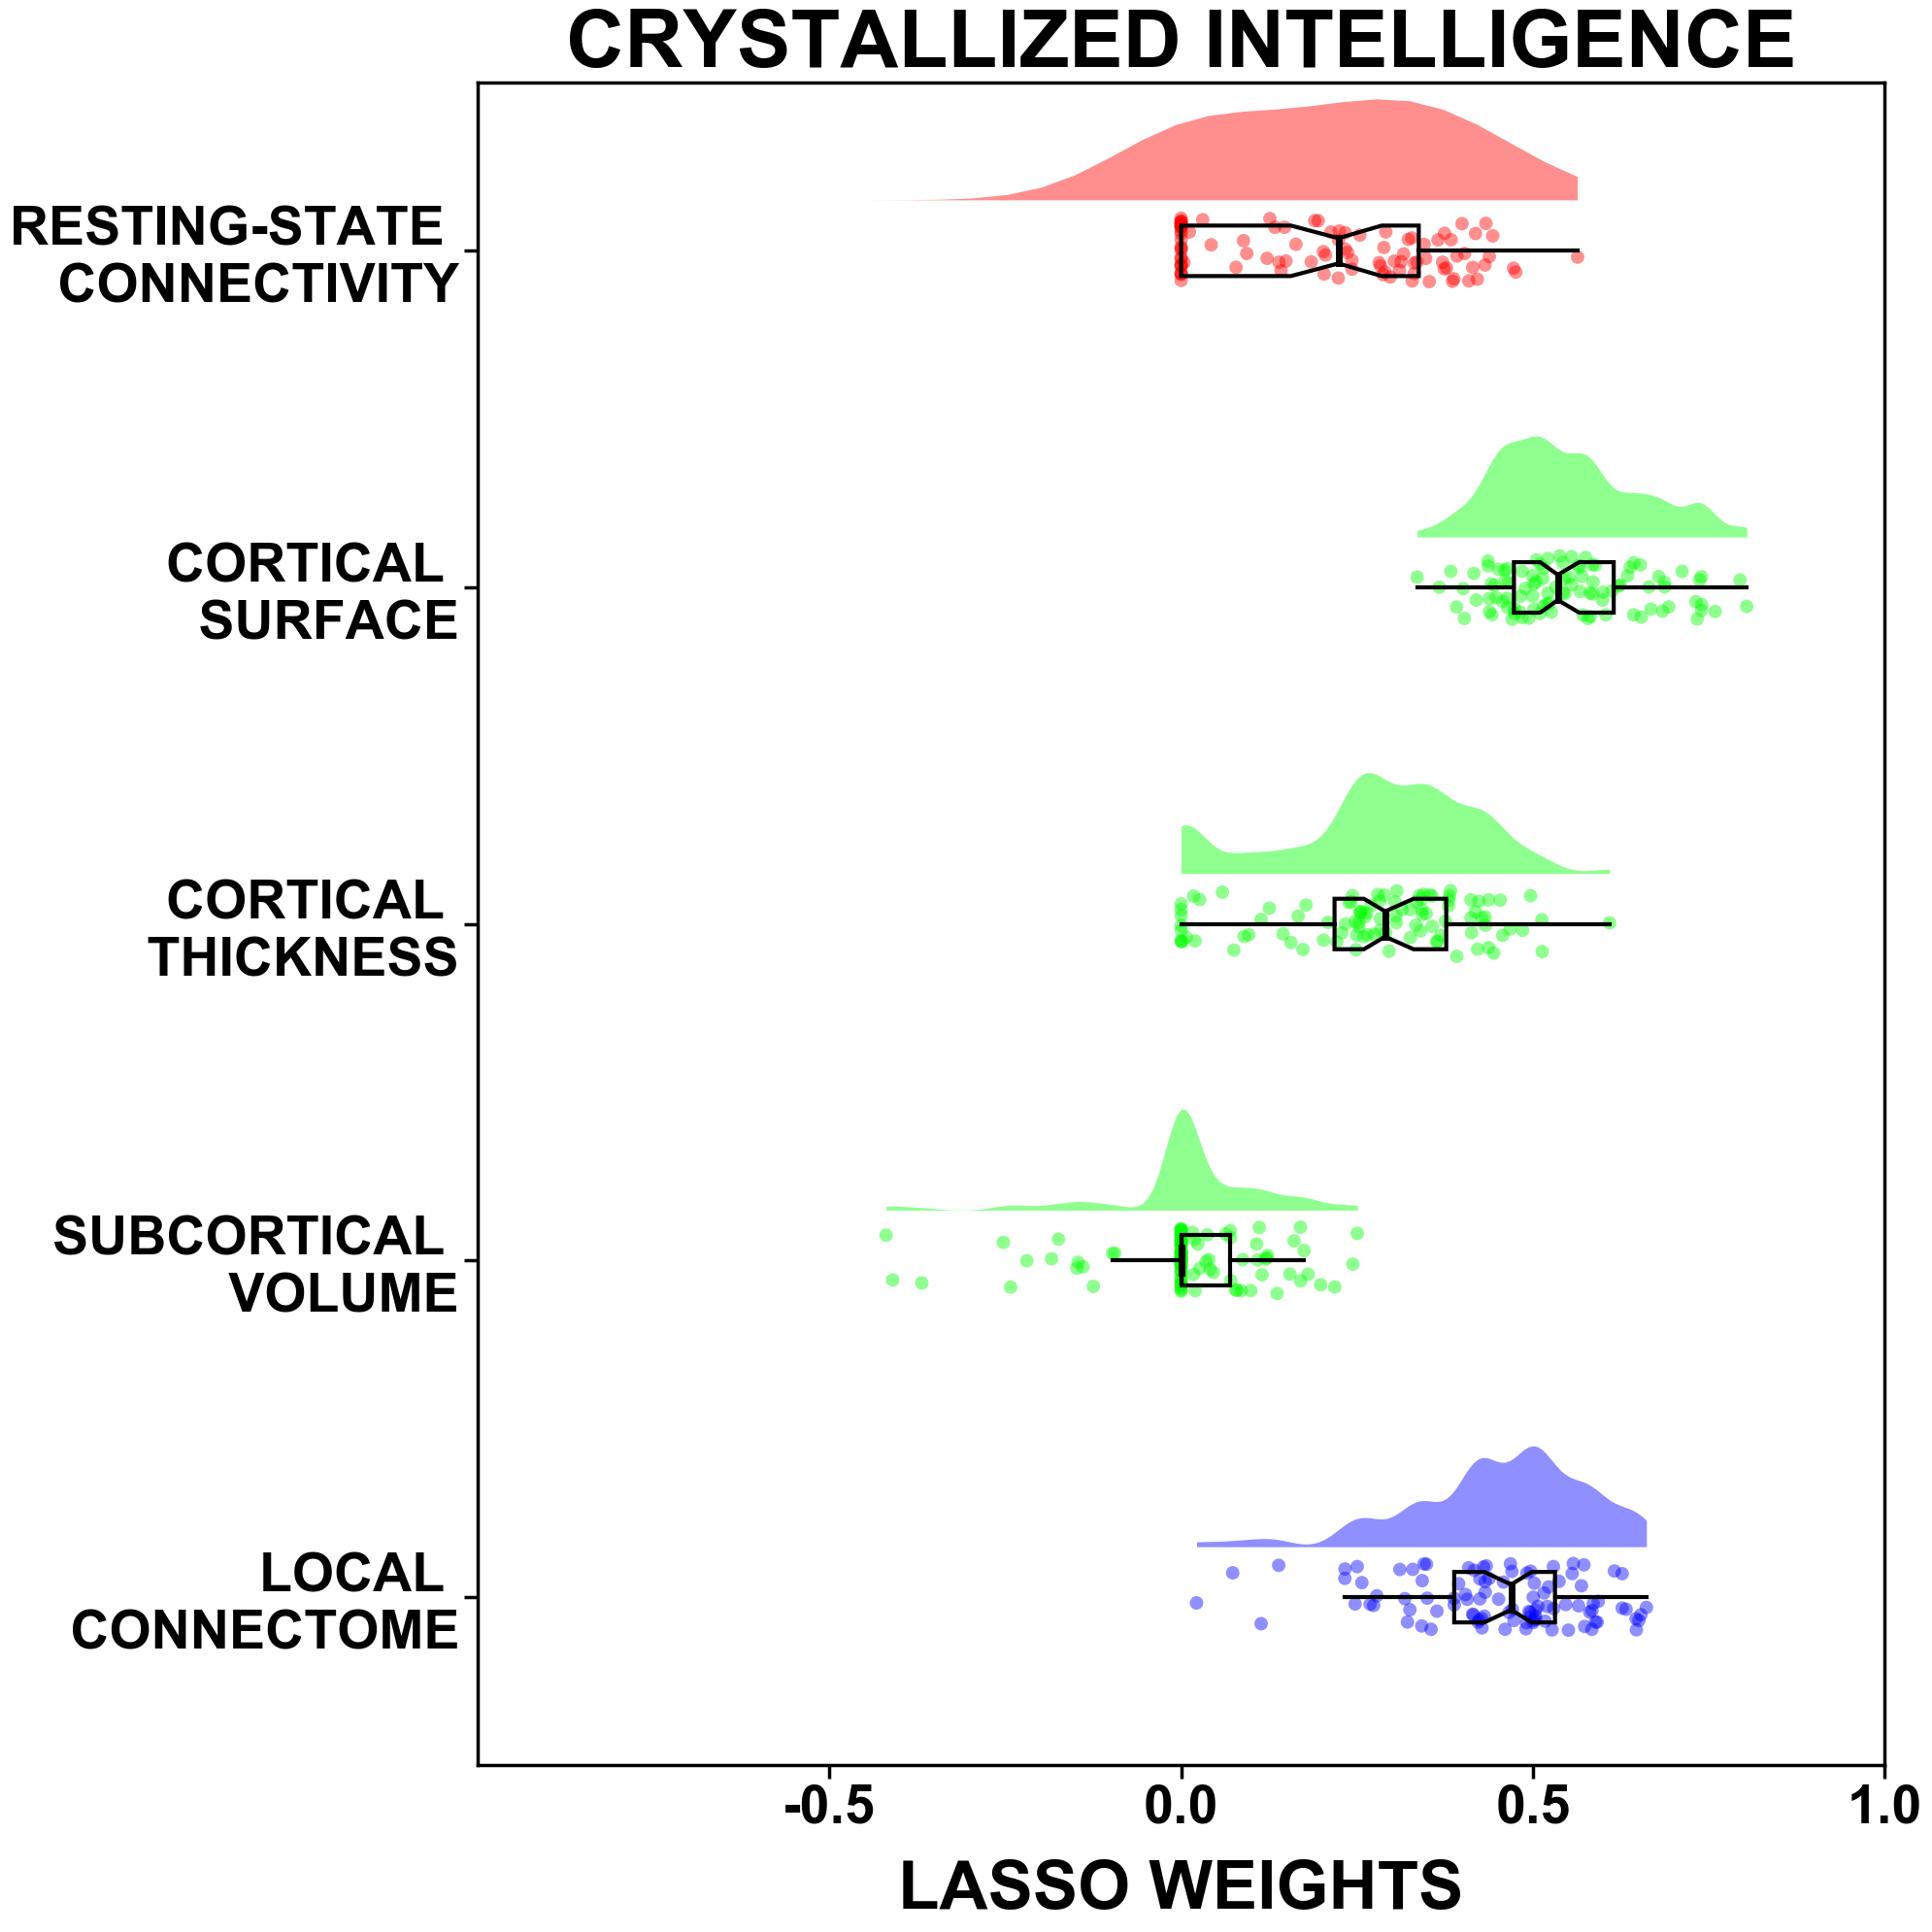

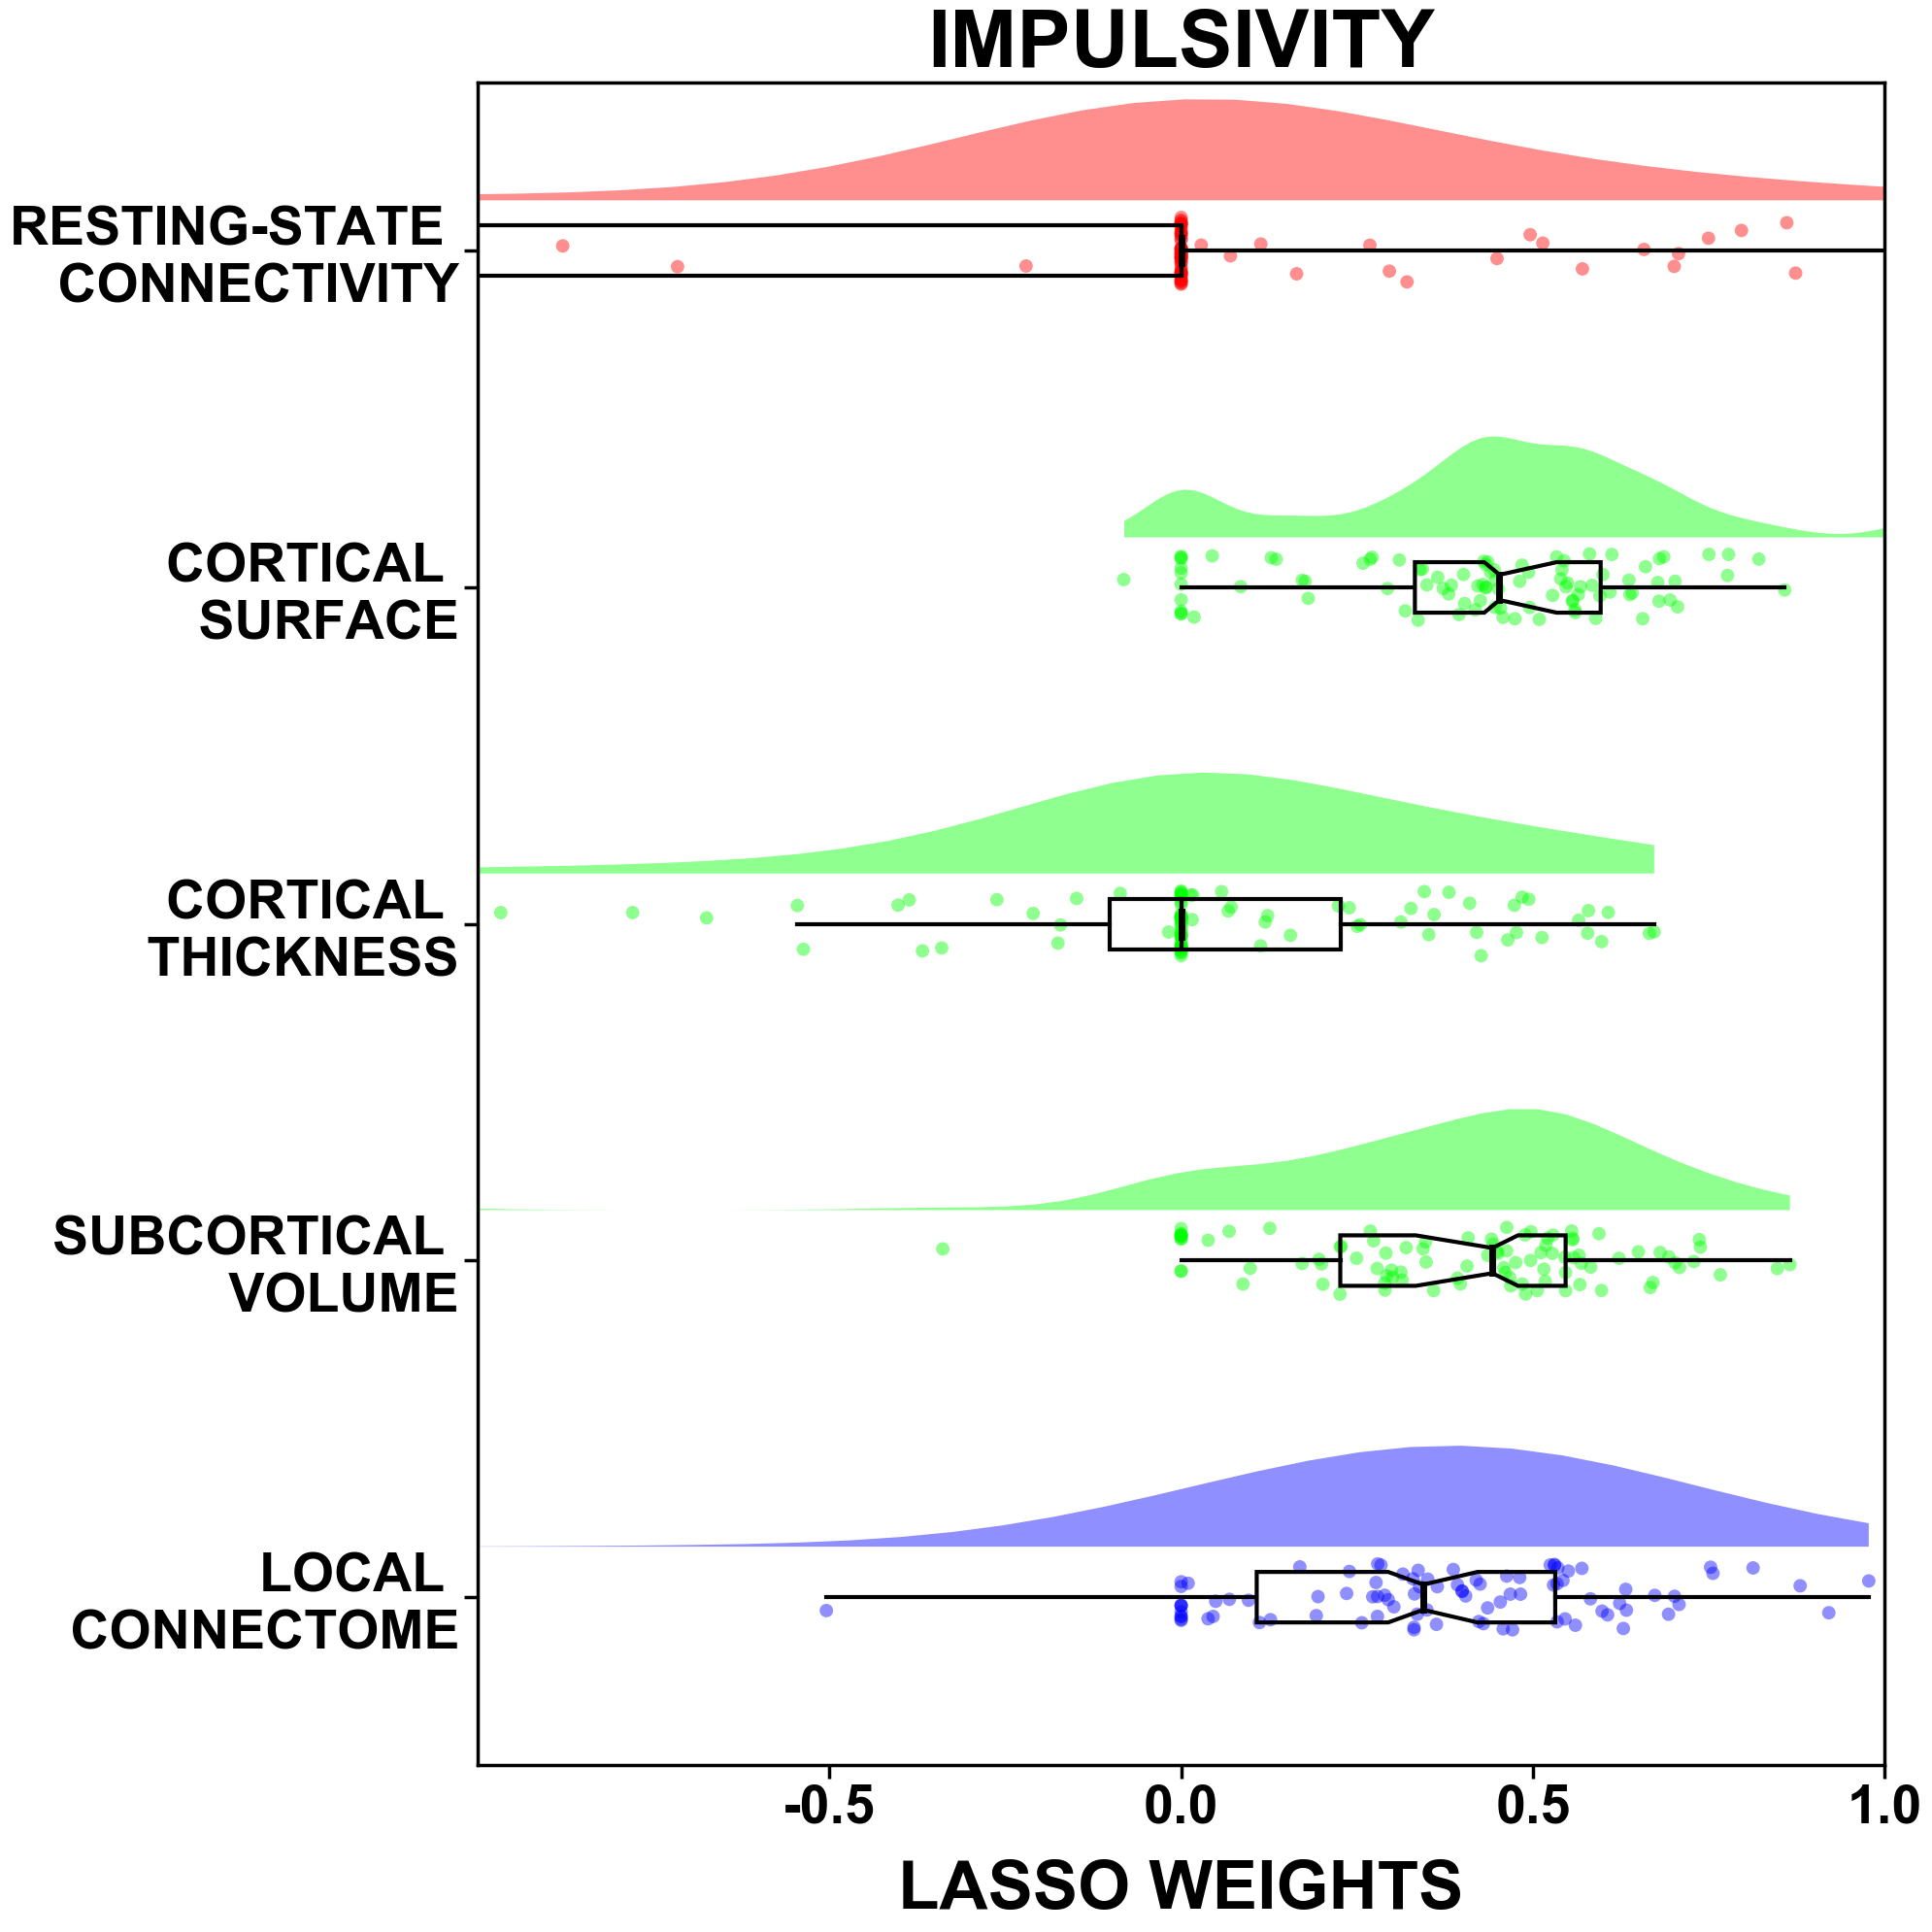

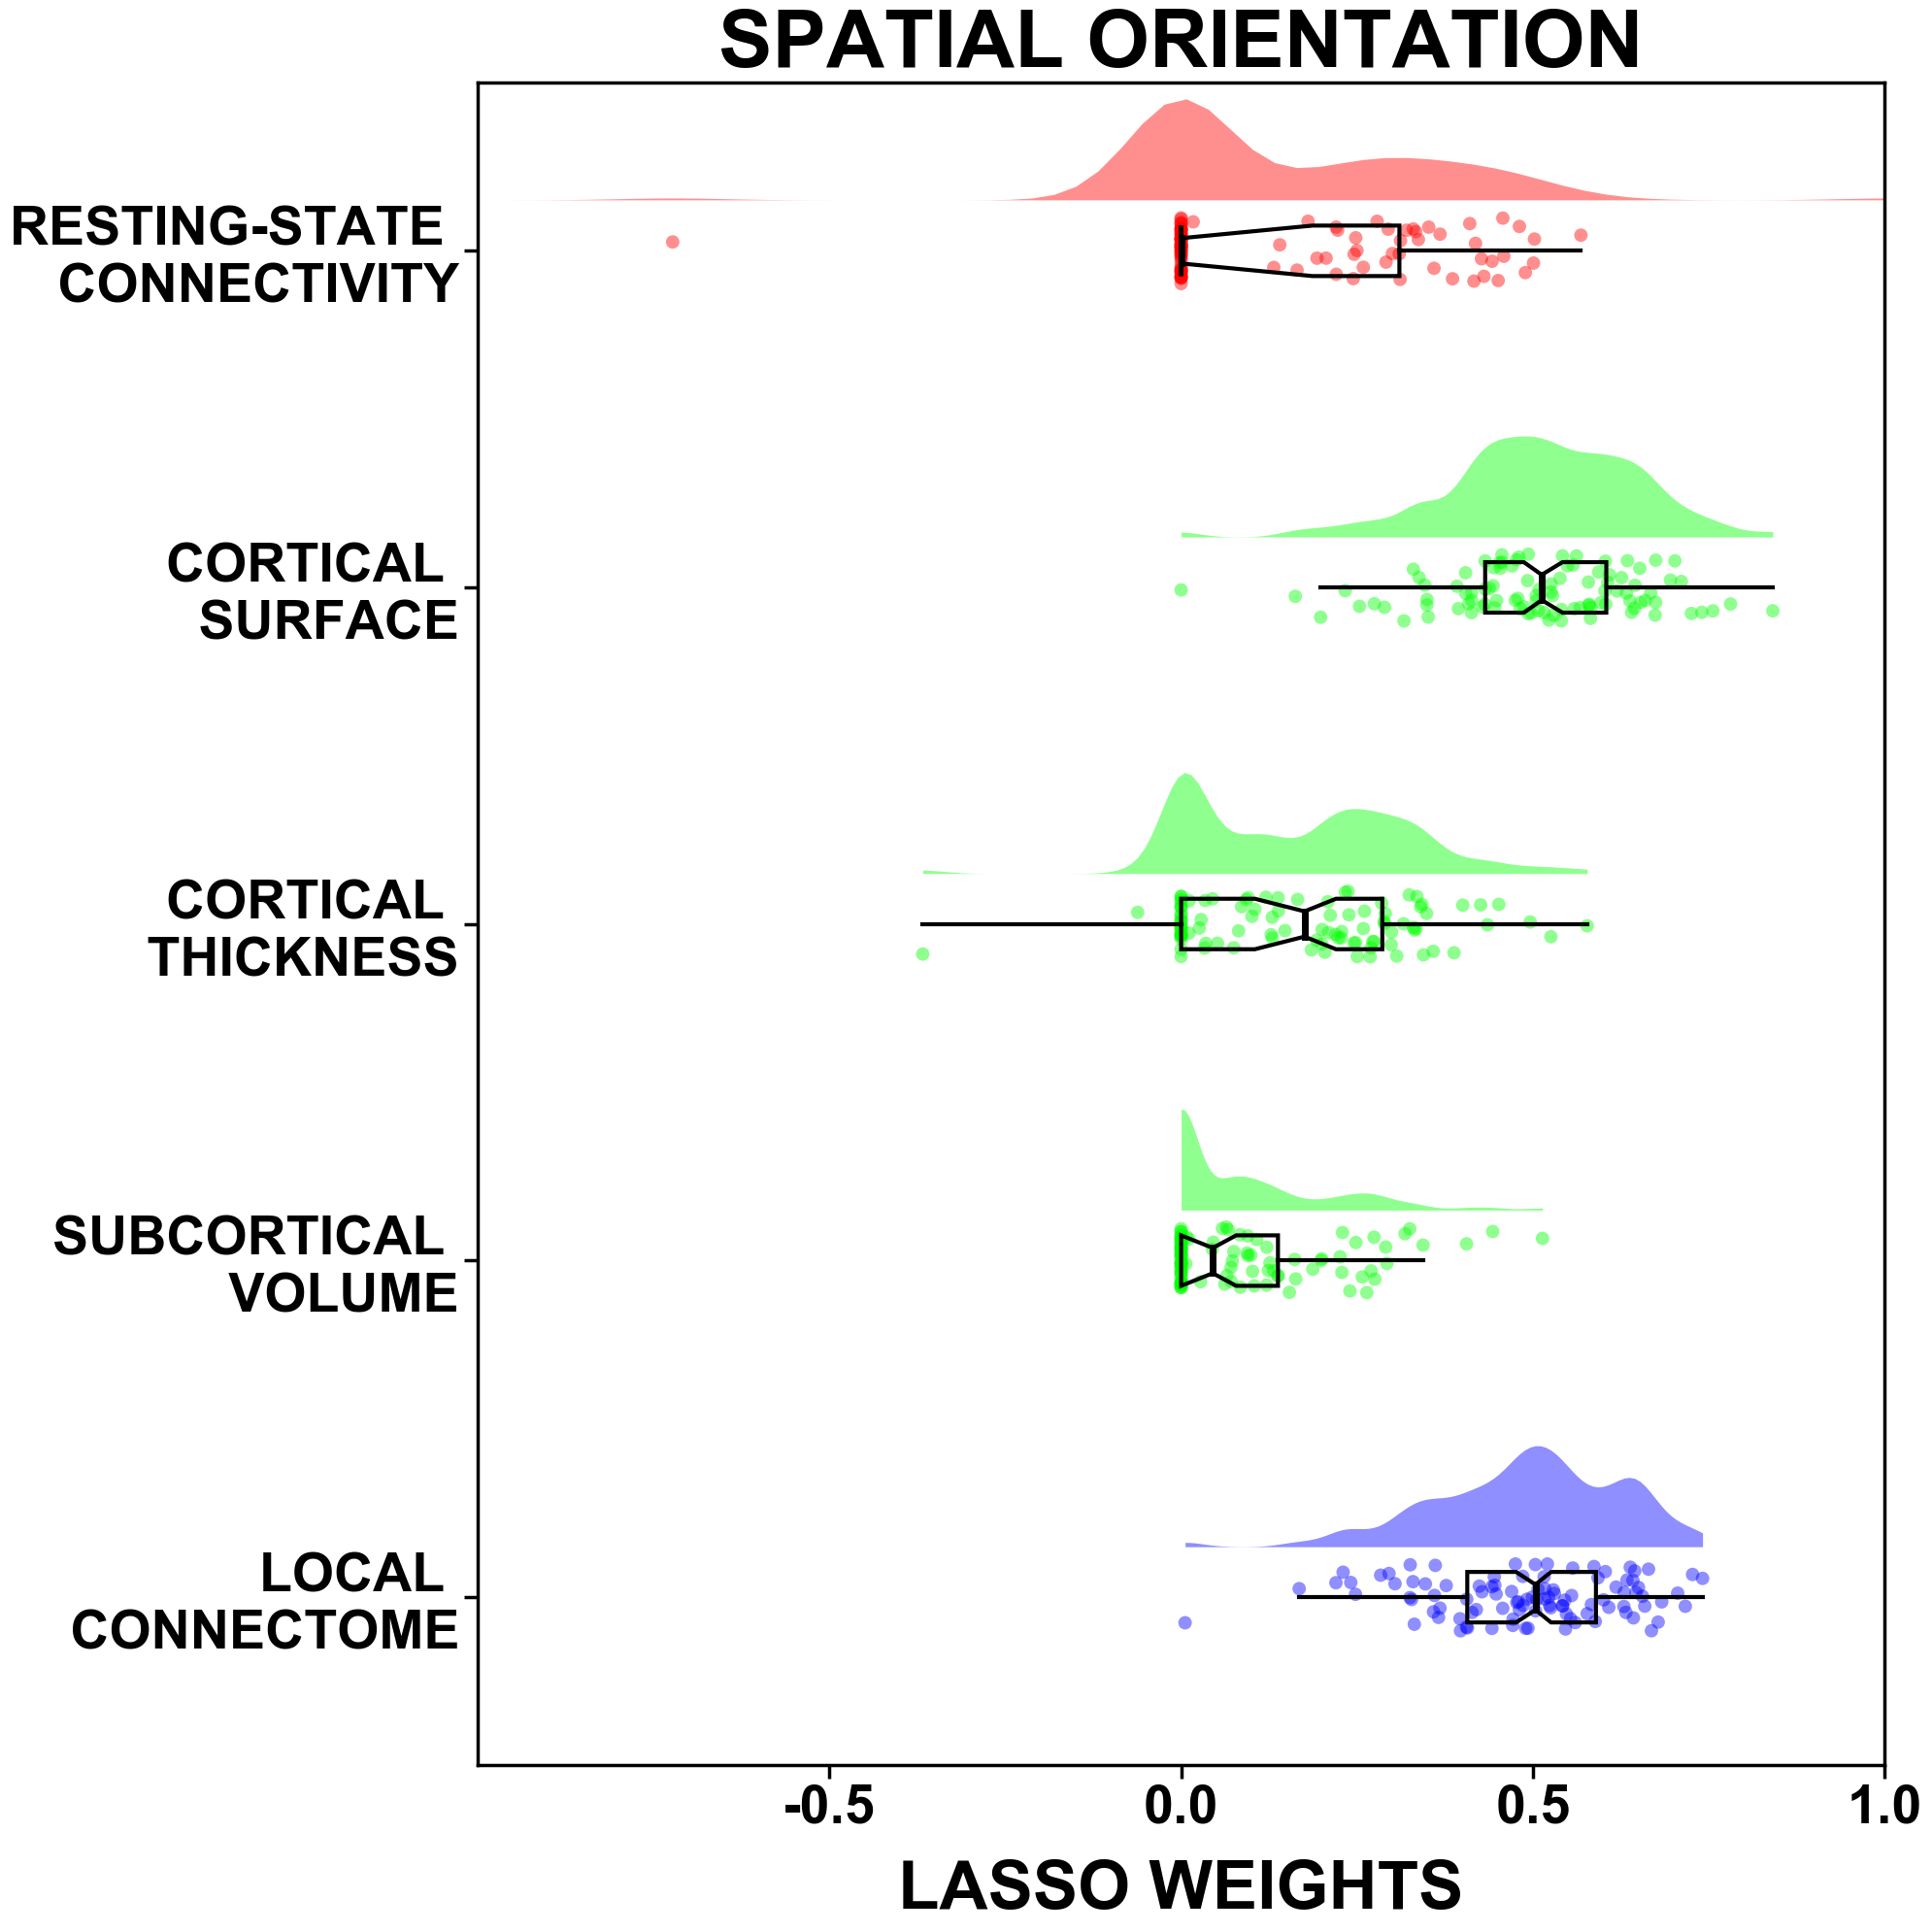

In [80]:
import ptitprince as pt
pal = [(1,0,0), (0,1,0),(0,1,0), (0,1,0),(0,0,1)]

for ii, score_id in enumerate([0, 1,2, 4, 6]):

    with plt.style.context(['default', 
                            {'font.family':'Arial',
                             'xtick.major.width':2.5,
                             'xtick.major.size':10,
                             'ytick.major.width':2.5,
                             'ytick.major.size':10,
                             'axes.linewidth':2.5
                  }]):

        fig, ax = plt.subplots(figsize=(20, 20))

        w_df = pd.DataFrame(data = comb_weights[:, score_id,:], 
                            columns=modality_names)

        pt.half_violinplot( x = 'value', y = 'variable', 
                              data = pd.melt(w_df), palette = pal, bw = .2, cut = 0.,
                              scale = "count", width = .6, inner = None, 
                              orient = 'h', linewidth=0.0, saturation=1, ax=ax)

        sns.stripplot( x = 'value', y = 'variable', data = pd.melt(w_df), edgecolor = "white",
                         size = 10, jitter = 1, zorder = 0, orient = 'h', palette=pal, alpha=0.1, ax=ax)

        plt.setp(ax.collections + ax.artists, alpha = 0.44)

        sns.boxplot(x = 'value', y = 'variable', data = pd.melt(w_df), 
                       color = "black", width = .15, zorder = 10,
                    notch=True,
                    bootstrap=1000,
                       showcaps = False, 
                       boxprops = {'facecolor':'none', "zorder":10, 'linewidth':3},
                    medianprops = {'linewidth':5},
                       showfliers=False, whiskerprops = {'linewidth':3, "zorder":10},
                       saturation = 1, orient = 'h', ax= ax)

        ax.set_xlabel("")
        ax.set_yticklabels(modality_names, size=40, weight='bold', rotation=0)

        ax.set_ylabel("")
        ax.set_xlim([-1, 1])
        ax.set_xticks([-0.5, 0, 0.5, 1])
        xlabels = ax.get_xticks().tolist().copy()
        ax.set_xticklabels(xlabels, size=40, weight='bold')
        ax.set_title(score_names[score_id].upper(),  size=60, weight='bold')

        ax.set_xlabel(r"LASSO WEIGHTS", labelpad=20, size=50, weight='bold')
        #sns.despine(fig=fig, trim=True)
        plt.tight_layout()
        #plt.savefig("../plots/lasso_weights/%s.png" % score_names[score_id], dpi=600)
        #plt.savefig("../plots/lasso_weights/%s.svg" % score_names[score_id], dpi=600)